## PD - Probability of Default

This notebook aims to come up with a general methodology for selecting features for PD model - as well as for finding the best categories for the features.

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from statsmodels.api import Logit

from credit_risk_modeling.cleaning import DatetimeConverter, NumericExtractor, NumericWinsorizer
from credit_risk_modeling.feature_engineering import TimeSinceCalculator, OHECategoriesCreator, NumericCategoriesCreator
from credit_risk_modeling.eda import compute_woe, plot_woe_by_category, get_fine_classes

#### Get data and select columns

In [2]:
selected_cols = [
    "id", "member_id", "loan_amnt", "funded_amnt", "term", "int_rate", "installment", "grade", "emp_length", 
    "home_ownership", "annual_inc", "issue_d", "loan_status", "purpose", "addr_state", "dti", "delinq_2yrs", 
    "earliest_cr_line", "verification_status", "initial_list_status", "inq_last_6mths", "open_acc", "pub_rec", 
    "total_acc", "total_rev_hi_lim"
]

In [3]:
df = pd.read_csv("../data/loan_data.csv")
df = df.loc[:, selected_cols]

/Users/gfluz94/.credit-risk/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Clean, Preprocess and Create Features

In [4]:
df["earliest_cr_line"].isnull().sum()

29

In [5]:
df["earliest_cr_line"] = df["earliest_cr_line"].fillna(df["issue_d"])

In [6]:
datetime_cols = ["earliest_cr_line", "issue_d"]
datetime_format = "%b-%y"
time_unit = "month"
reference_date = datetime(2017, 12, 1)

datetime_converter = DatetimeConverter(
    field_names=datetime_cols,
    datetime_format=datetime_format
)
df = datetime_converter.transform(df)

for datetime_col in datetime_cols:
    time_since_calculator = TimeSinceCalculator(
        field_name=datetime_col, reference_date=reference_date, time_unit=time_unit, winsorize_max=True,
    )
    df = time_since_calculator.transform(df)

In [7]:
emp_length_extractor = NumericExtractor(
    field_name="emp_length",
    regex_extraction=r"(.+)\syears?",
    post_mapping={r"10\+\s?": str(10), r"< 1\s?": str(0)},
)
df = emp_length_extractor.transform(df)

emp_length_extractor = NumericExtractor(
    field_name="term",
    regex_extraction=r"(\d+)",
)
df = emp_length_extractor.transform(df)

In order for us to continue with the analysis, we just need to carry out two additional steps:

* Define target variable

In [8]:
DEFAULT_CATEGORIES = [
    "Charged Off",
    "Late (31-120 days)",
    "Default",
    "Does not meet the credit policy. Status:Charged Off"
]
TARGET_VARIABLE = "default"

df[TARGET_VARIABLE] = df["loan_status"].isin(DEFAULT_CATEGORIES).astype(float)
(df[TARGET_VARIABLE].value_counts() / len(df)).apply(lambda x: f"{100*x:.2f}%")

0.0    89.07%
1.0    10.93%
Name: default, dtype: object

* Split our dataset into training and test, so that we avoid data leakage at all costs.

In [9]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=99, stratify=df[TARGET_VARIABLE])

#### Categorical Features

It is time for us now to take a closer look at categorical variables and, according to WoE analysis, select the best categories for each feature.

We are going to analyze the following variables:

* `grade`
* `home_ownership`
* `addr_state`
* `verification_status`
* `purpose`
* `initial_list_status`

In [10]:
transformers = []
features = []
reference_categories = []

1. `grade`

In [11]:
variable = "grade"

In [12]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


B    109603
C    100372
D     61548
A     59796
E     28514
F     10502
G      2693
Name: grade, dtype: int64


In [13]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
grade,,,,,,,
A,57506,2290,59796,0.173078,0.056163,-1.125482,0.29095
B,100983,8620,109603,0.303933,0.211409,-0.363012,0.29095
C,88788,11584,100372,0.267229,0.284103,0.061228,0.29095
D,52076,9472,61548,0.156736,0.232305,0.393491,0.29095
E,22981,5533,28514,0.069167,0.135699,0.673917,0.29095
F,7960,2542,10502,0.023958,0.062344,0.956377,0.29095
G,1960,733,2693,0.005899,0.017977,1.114301,0.29095


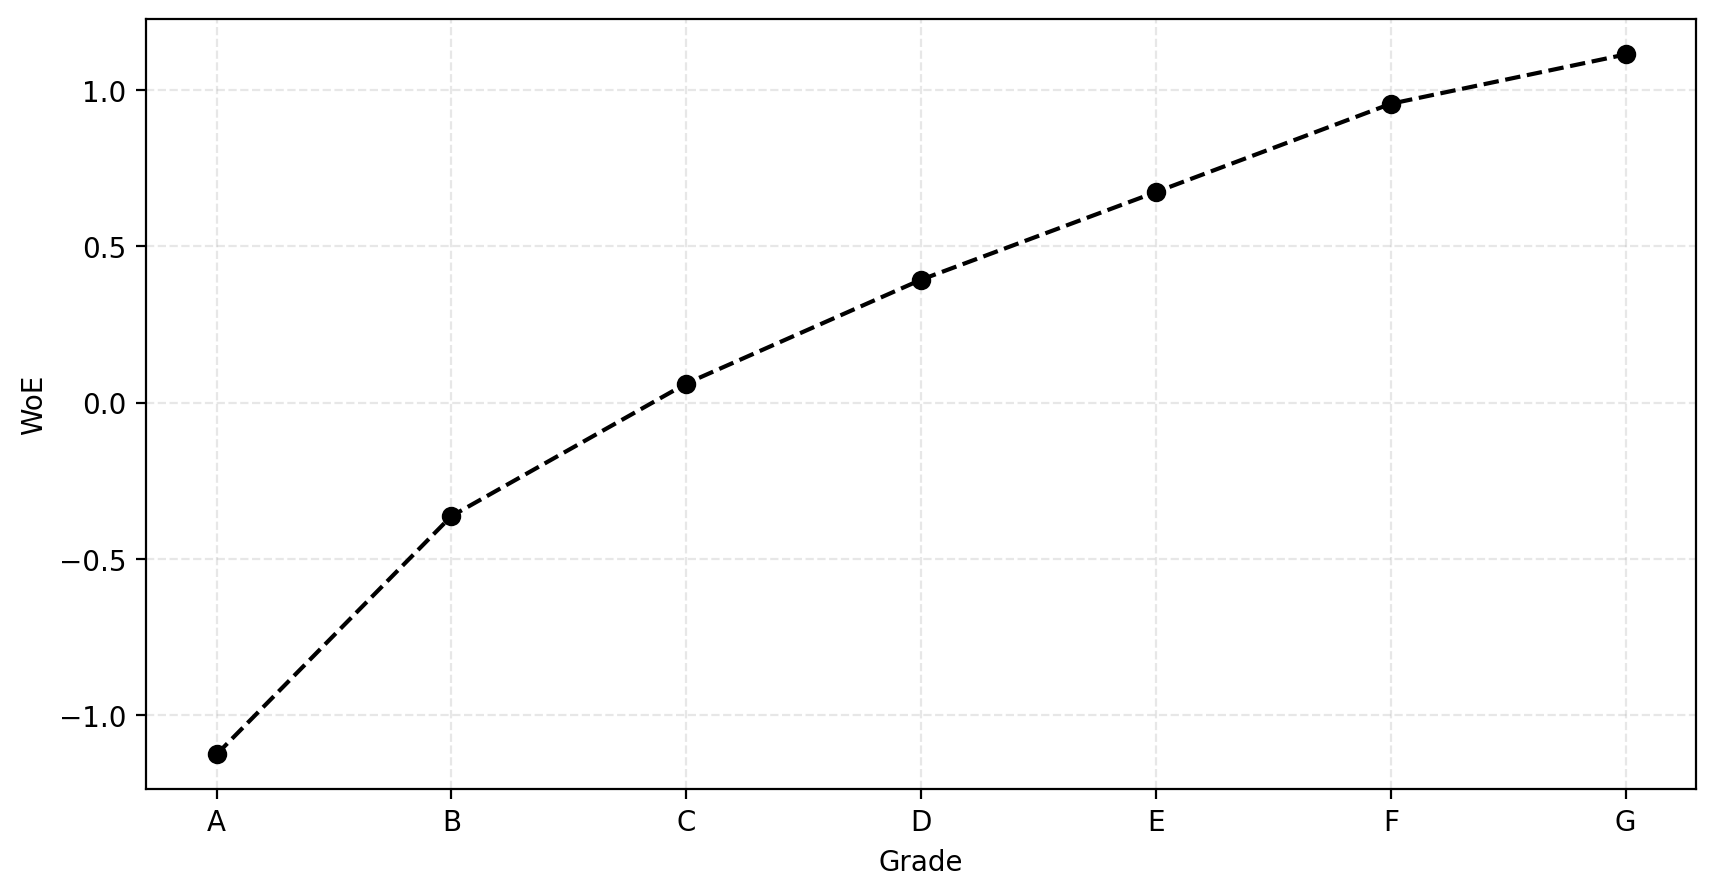

In [14]:
plot_woe_by_category(woe_df)

Based on the analysis above, we are going to keep the current seven categories (A -> G). We can notice that the curve almost increases monotonically, from A to G, meaning that A is the best score and G is the worst one.

In [15]:
final_categories = {
    "A": ["A"],
    "B": ["B"],
    "C": ["C"],
    "D": ["D"],
    "E": ["E"],
    "F": ["F"],
    "G": ["G"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [16]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "G")

2. `home_ownership`

In [17]:
variable = "home_ownership"

In [18]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


MORTGAGE    188830
RENT        150642
OWN          33364
OTHER          152
NONE            39
ANY              1
Name: home_ownership, dtype: int64


In [19]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
home_ownership,,,,,,,
MORTGAGE,170688.0,18142.0,188830.0,0.513727,0.444940,-0.143753,0.021492
OWN,29755.0,3609.0,33364.0,0.089555,0.088512,-0.011711,0.021492
RENT,131658.0,18984.0,150642.0,0.396257,0.465591,0.161244,0.021492
NONE,34.0,5.0,39.0,0.000102,0.000123,0.180933,0.021492
OTHER,118.0,34.0,152.0,0.000355,0.000834,0.853531,0.021492
ANY,1.0,NaN,1.0,0.000003,NaN,NaN,0.021492


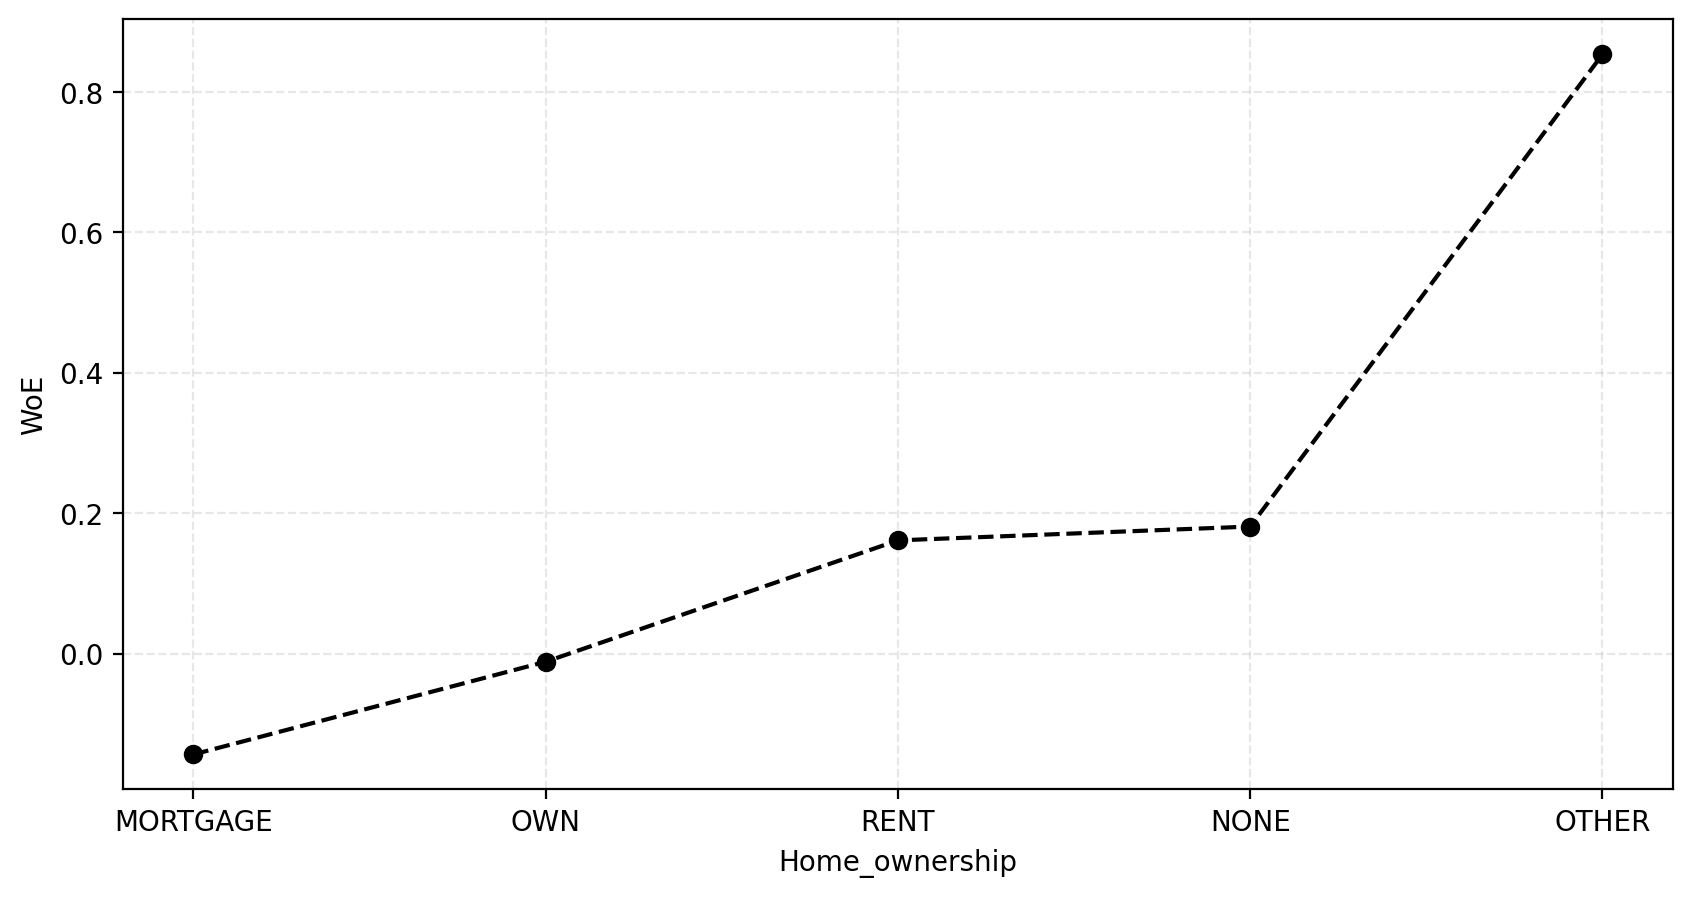

In [20]:
plot_woe_by_category(woe_df)

From the WoE resultsa above, we can notice that `NONE`, `OTHER` and `ANY` are not representative, due to small number of observations. Also, their meaning is not clear, hence from a **conservative risk-management attitude**, we should assume the worst or highest-risk - in this case, `RENT`.

In [21]:
df_train_ = df_train.copy()
df_train_[variable] = np.where(
    df_train_[variable].isin(["NONE", "OTHER", "RENT", "ANY"]),
    "NONE_OTHER_RENT_ANY",
    df_train_[variable]
)
woe_df = compute_woe(
    df=df_train_,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
home_ownership,,,,,,,
MORTGAGE,170688,18142,188830,0.513727,0.444940,-0.143753,0.021222
OWN,29755,3609,33364,0.089555,0.088512,-0.011711,0.021222
NONE_OTHER_RENT_ANY,131811,19023,150834,0.396718,0.466547,0.162135,0.021222


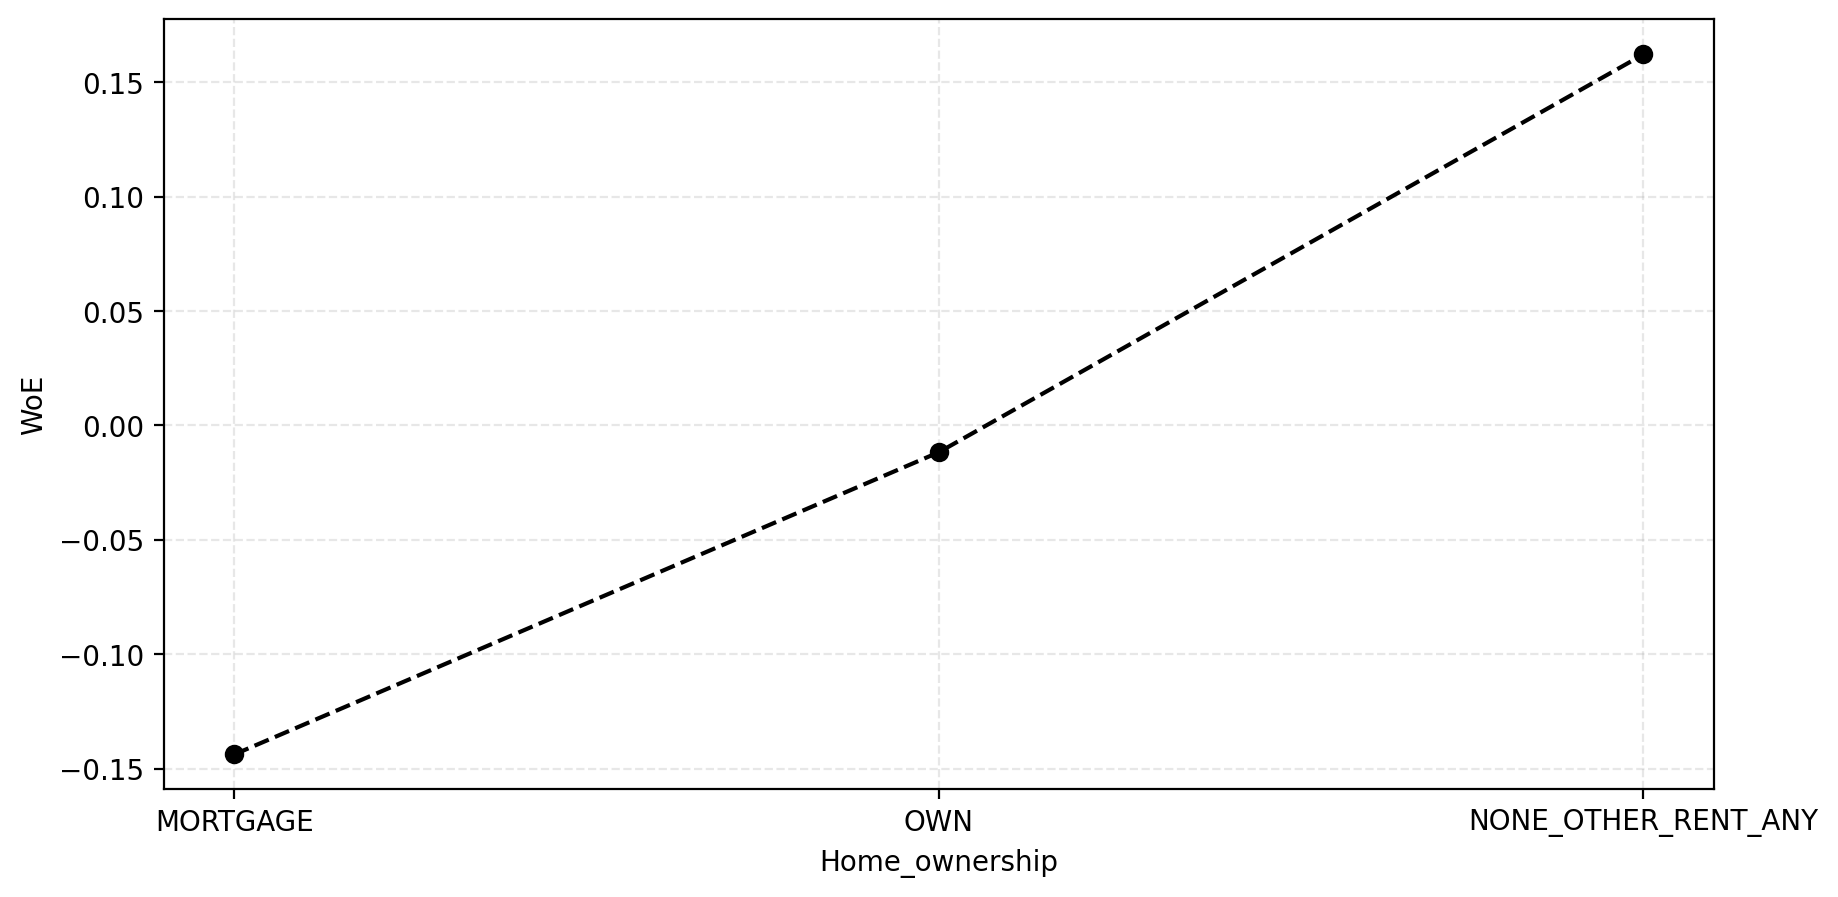

In [22]:
plot_woe_by_category(woe_df)

In [23]:
final_categories = {
    "NONE_OTHER_RENT_ANY": ["NONE", "OTHER", "RENT", "ANY"],
    "MORTGAGE": ["MORTGAGE"],
    "OWN": ["OWN"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [24]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "NONE_OTHER_RENT_ANY")

3. `addr_state`

In [25]:
variable = "addr_state"

In [26]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].unique())
print(df_train[variable].nunique())

0.00% missing!


['CA' 'TX' 'IL' 'NY' 'PA' 'FL' 'MD' 'KS' 'AL' 'WA' 'AZ' 'NC' 'SC' 'GA'
 'IN' 'NJ' 'OR' 'MI' 'NV' 'OK' 'VA' 'WY' 'CT' 'NM' 'OH' 'MO' 'TN' 'CO'
 'MA' 'WV' 'NH' 'LA' 'DE' 'KY' 'UT' 'VT' 'AR' 'WI' 'HI' 'MN' 'DC' 'MT'
 'RI' 'SD' 'MS' 'AK' 'NE' 'ID' 'ME' 'IA']
50


From the list above, since we would expect 50 states + 1 DC, we realize that `ND` is missing. Let's add it then to the `highest-risk-category`.

In [27]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
addr_state,,,,,,,
DC,1074.0,78.0,1152.0,0.003232,0.001913,-0.524581,0.013262
WY,831.0,67.0,898.0,0.002501,0.001643,-0.420082,0.013262
NH,1632.0,145.0,1777.0,0.004912,0.003556,-0.322973,0.013262
MS,907.0,82.0,989.0,0.002730,0.002011,-0.305568,0.013262
AK,915.0,83.0,998.0,0.002754,0.002036,-0.302228,0.013262
MT,1032.0,94.0,1126.0,0.003106,0.002305,-0.298104,0.013262
VT,667.0,61.0,728.0,0.002008,0.001496,-0.294061,0.013262
WV,1738.0,168.0,1906.0,0.005231,0.004120,-0.238671,0.013262
KS,3045.0,296.0,3341.0,0.009165,0.007260,-0.233042,0.013262


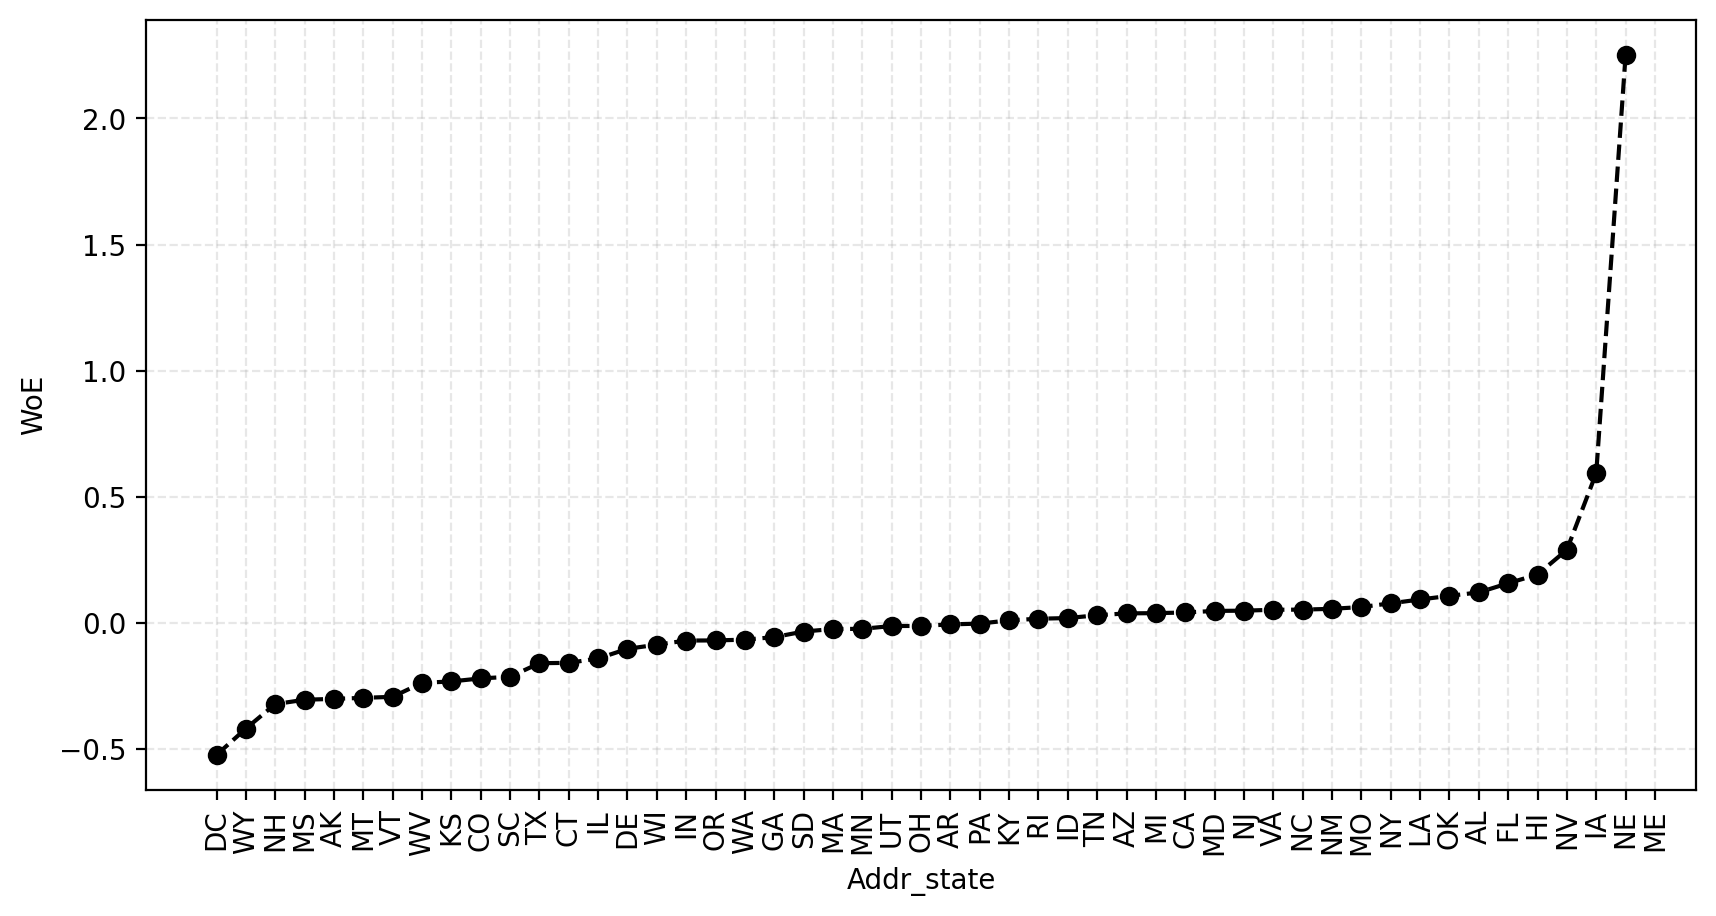

In [28]:
plot_woe_by_category(woe_df, rotate=True)

This visualization could be misleading due to the scale... Last 3 categories (`ME`, `NE` and `IA`) are not representative, hence let's keep them out for a while.

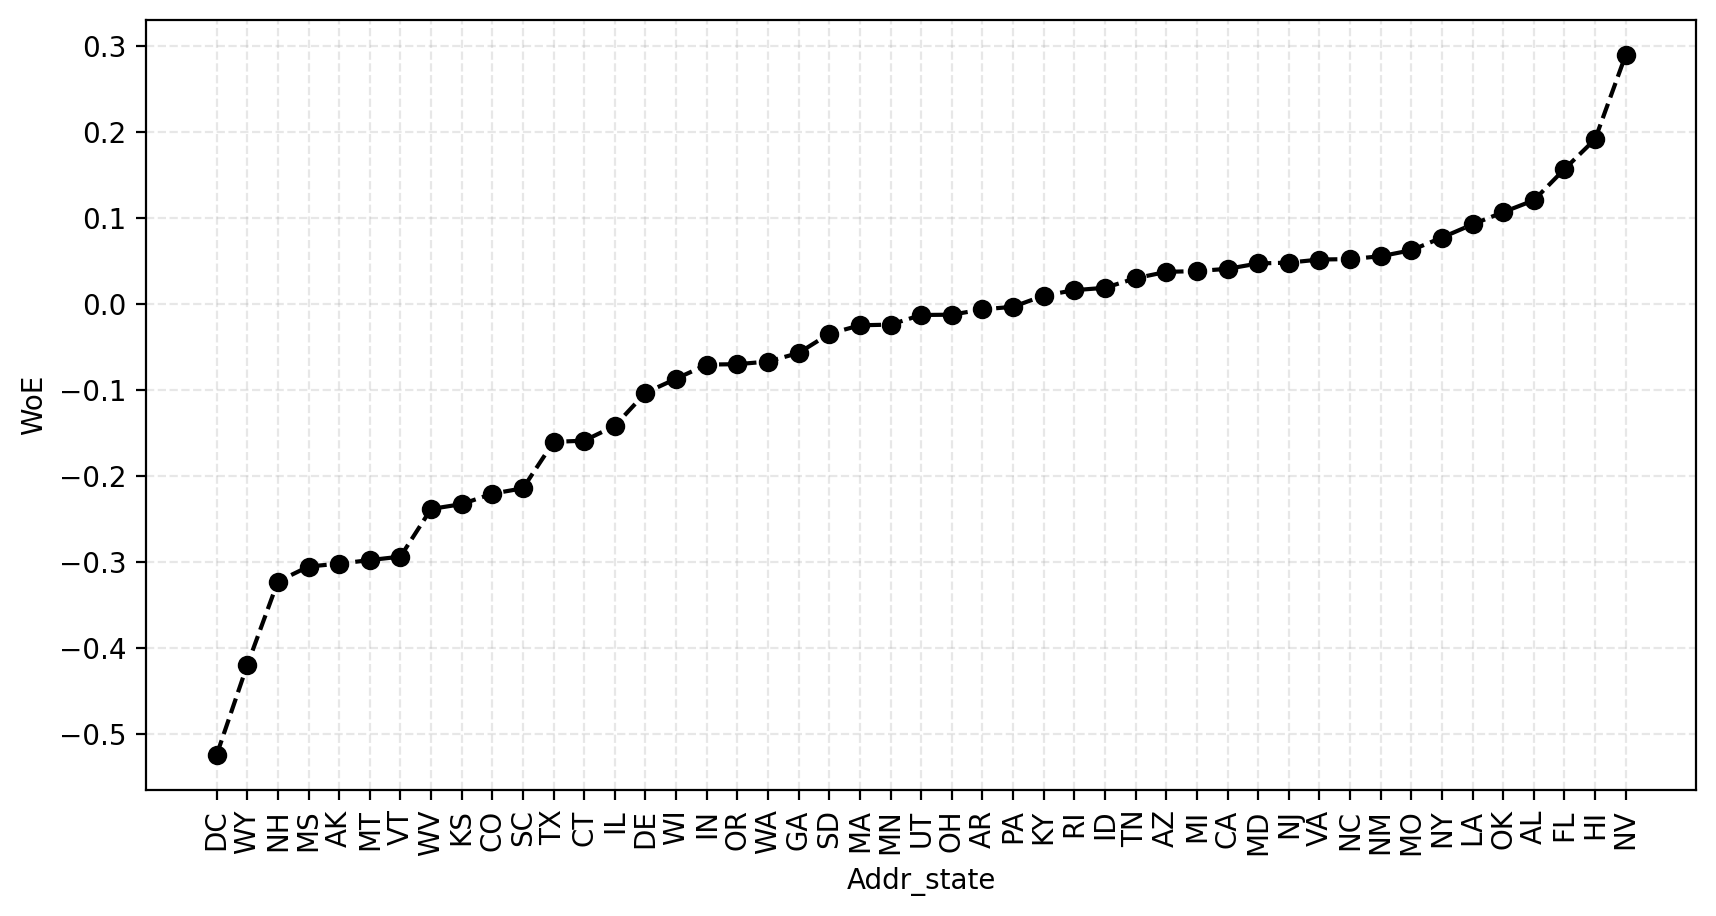

In [29]:
plot_woe_by_category(woe_df.iloc[:-3, :], rotate=True)

In a descending order:

* `NV` stands out from `HI` and is representative, so it should be a separate category that includes the missing state (`ND`) and the 3 non-representative ones above it (`ME`, `NE` and `IA`)

* `HI` has a higher WoE than `FL`, which stands out a lot (22k). So both should be kept as categories of their own

* `AL`, `OK` and `LA` should be groupped together

* Even though `NY` has similar WoE to its neighbours in the table, it stands out, so let's keep it apart

* `MO` should be kept as a different category

* `MD`, `NJ`, `VA`, `NC`, `NM` and `MD` should be groupped together

* Even though `CA` has similar WoE to its neighbours in the table, it stands out, so let's keep it apart

* `TN`, `AZ` and `MI` should be groupped together

* `KY`, `RI` and `ID` should be groupped together

* `PA`, `AR`, `OH` and `UT` should be groupped together

* `MN`, `MA` and `SD` should be groupped together

* `IN`, `OR`, `WA` and `GA` should be groupped together

* `WI` and `DE` should be groupped together (due to the fact that DE is not representative)

* `IL`, `TX` and `CT` should be kept as separate categories. `TX` and `CT` have similar WoE, but `TX` really stands out

* `WV`, `KS`, `CO` and `SC` should be groupped together

* `MS`, `AK`, `MT` and `VT` should be groupped together

* `NH`, `WY` and `DC` have different WoE, however they are not representative. Since they are on the edge of the spectrum, we group them together

In [30]:
final_categories = {
    "NV_ND_ME_NE_IA": ["NV", "ND", "ME", "NE", "IA"],
    "HI": ["HI"],
    "FL": ["FL"],
    "AL_OK_LA": ["AL", "OK", "LA"],
    "NY": ["NY"],
    "MO": ["MO"],
    "MD_NJ_VA_NC_NM": ["NJ", "VA", "NC", "NM", "MD"],
    "CA": ["CA"],
    "TN_AZ_MI": ["TN", "AZ", "MI"],
    "KY_RI_ID": ["KY", "RI", "ID"],
    "PA_AR_OH_UT": ["PA", "AR", "OH", "UT"],
    "MN_MA_SD": ["MN", "MA", "SD"],
    "IN_OR_WA_GA": ["IN", "OR", "WA", "GA"],
    "WI_DE": ["WI", "DE"],
    "IL": ["IL"],
    "TX": ["TX"],
    "CT": ["CT"],
    "WV_KS_CO_SC": ["WV", "KS", "CO", "SC"],
    "MS_AK_MT_VT": ["MS", "AK", "MT", "VT"],
    "NH_WY_DC": ["NH", "WY", "DC"],   
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [31]:
df_train[filter(lambda x: x.startswith(variable), df_train.columns)].sum(axis=1).sum() == len(df_train)

True

In [32]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "NV_ND_ME_NE_IA")

4. `verification_status`

In [33]:
variable = "verification_status"

In [34]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


Verified           134457
Source Verified    119799
Not Verified       118772
Name: verification_status, dtype: int64


In [35]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
verification_status,,,,,,,
Not Verified,107487,11285,118772,0.323509,0.276770,-0.156040,0.018866
Source Verified,107329,12470,119799,0.323033,0.305832,-0.054718,0.018866
Verified,117438,17019,134457,0.353458,0.417398,0.166275,0.018866


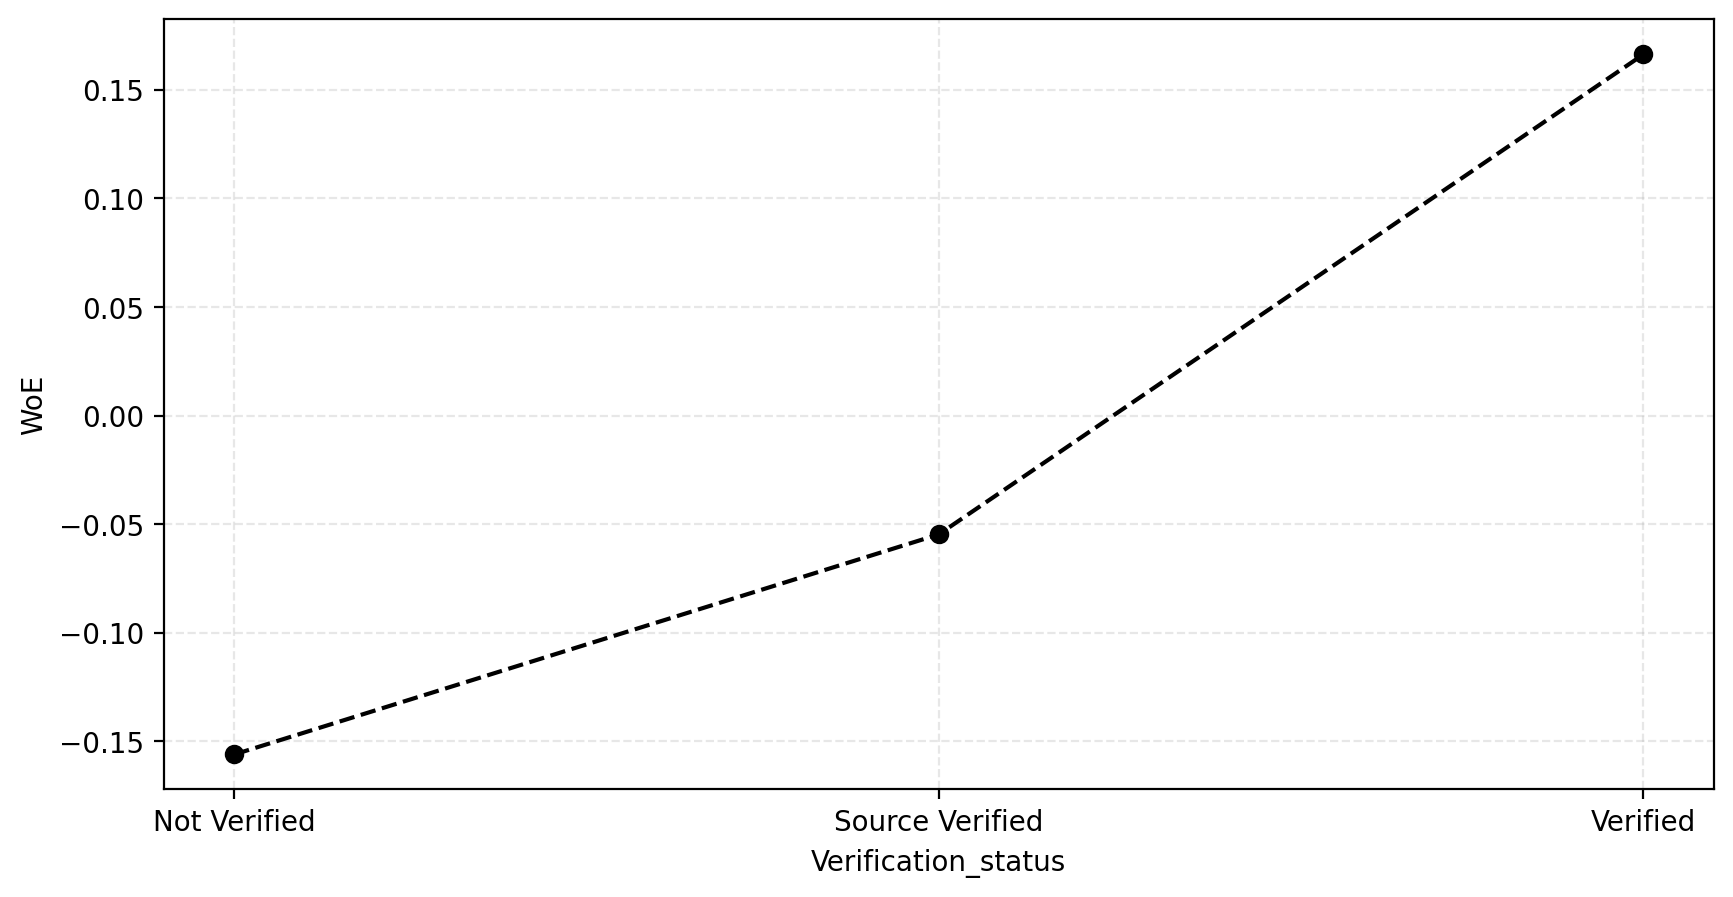

In [36]:
plot_woe_by_category(woe_df)

From the WoE resultsa above, we can notice that WoE almost increases monotonically. Hence, we are good to go.

In [37]:
final_categories = {
    v: [v] for v in df_train[variable].unique()
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [38]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "Verified")

5. `purpose`

In [39]:
variable = "purpose"

In [40]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


debt_consolidation    219434
credit_card            83206
home_improvement       21215
other                  19049
major_purchase          7893
small_business          5619
car                     4316
medical                 3658
moving                  2359
vacation                1949
wedding                 1890
house                   1831
educational              323
renewable_energy         286
Name: purpose, dtype: int64


In [41]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
purpose,,,,,,,
car,3951,365,4316,0.011892,0.008952,-0.283972,0.036922
credit_card,76044,7162,83206,0.228873,0.175651,-0.264668,0.036922
major_purchase,7129,764,7893,0.021456,0.018737,-0.135503,0.036922
home_improvement,19126,2089,21215,0.057564,0.051234,-0.116508,0.036922
debt_consolidation,194540,24894,219434,0.585516,0.610536,0.041844,0.036922
vacation,1720,229,1949,0.005177,0.005616,0.081498,0.036922
wedding,1657,233,1890,0.004987,0.005714,0.136130,0.036922
medical,3168,490,3658,0.009535,0.012017,0.231405,0.036922
other,16442,2607,19049,0.049486,0.063938,0.256216,0.036922


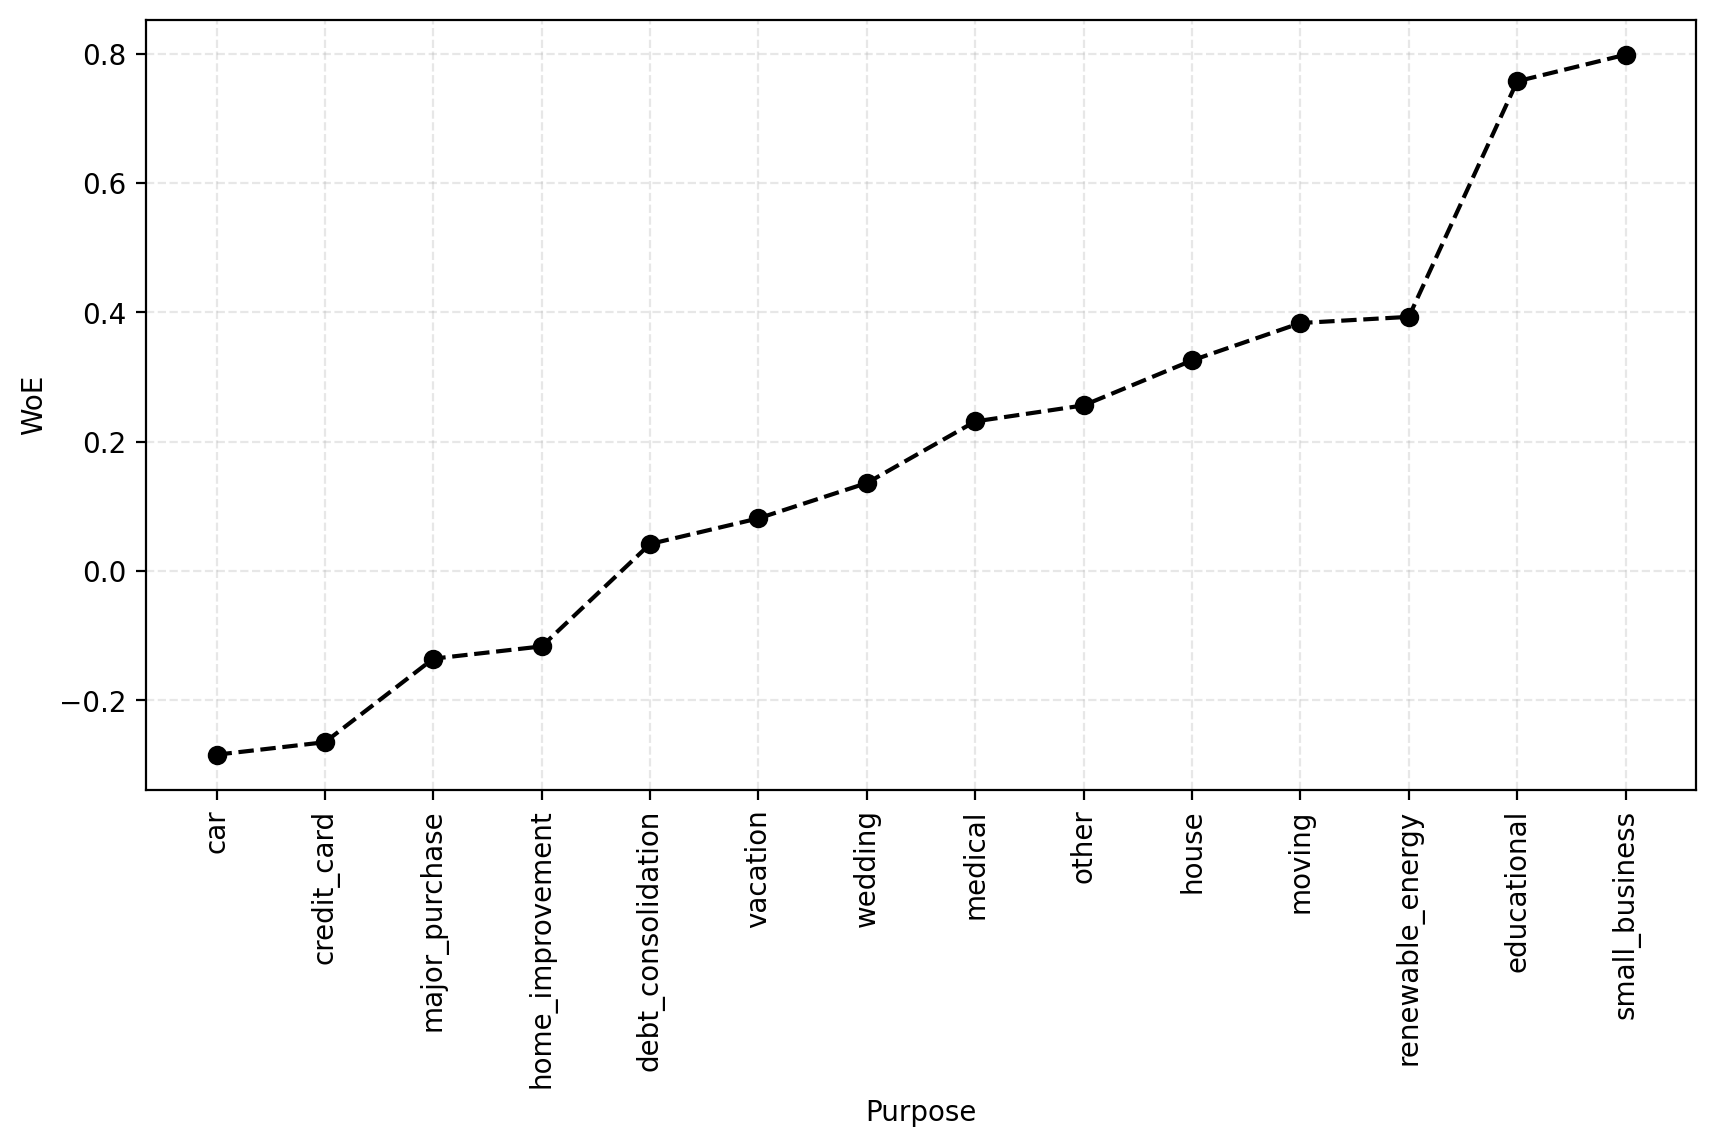

In [42]:
plot_woe_by_category(woe_df, rotate=True)

From the results above, the only categories that should be groupped together are:

* `educational` and `small_business`

* `house`, `moving` and `renewable_energy`

* `vacation` and `wedding`

* `major_purchase` and `home_improvement`

In [43]:
final_categories = {
    "car": ["car"],
    "credit_card": ["credit_card"],
    "major_purchase_home_improvement": ["major_purchase", "home_improvement"],
    "debt_consolidation": ["debt_consolidation"],
    "vacation_wedding": ["vacation", "wedding"],
    "medical": ['medical'],
    "other": ["other"],
    "renewable_energy_house_moving": ["renewable_energy", "house", "moving"],
    "educational_small_business": ["small_business", "educational"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [44]:
df_train[filter(lambda x: x.startswith(variable), df_train.columns)].sum(axis=1).sum() == len(df_train)

True

In [45]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "educational_small_business")

6. `initial_list_status`

In [46]:
variable = "initial_list_status"

In [47]:
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

0.00% missing!


f    242532
w    130496
Name: initial_list_status, dtype: int64


In [48]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
woe_df

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
initial_list_status,,,,,,,
w,118893,11603,130496,0.357838,0.284569,-0.229105,0.024703
f,213361,29171,242532,0.642162,0.715431,0.108045,0.024703


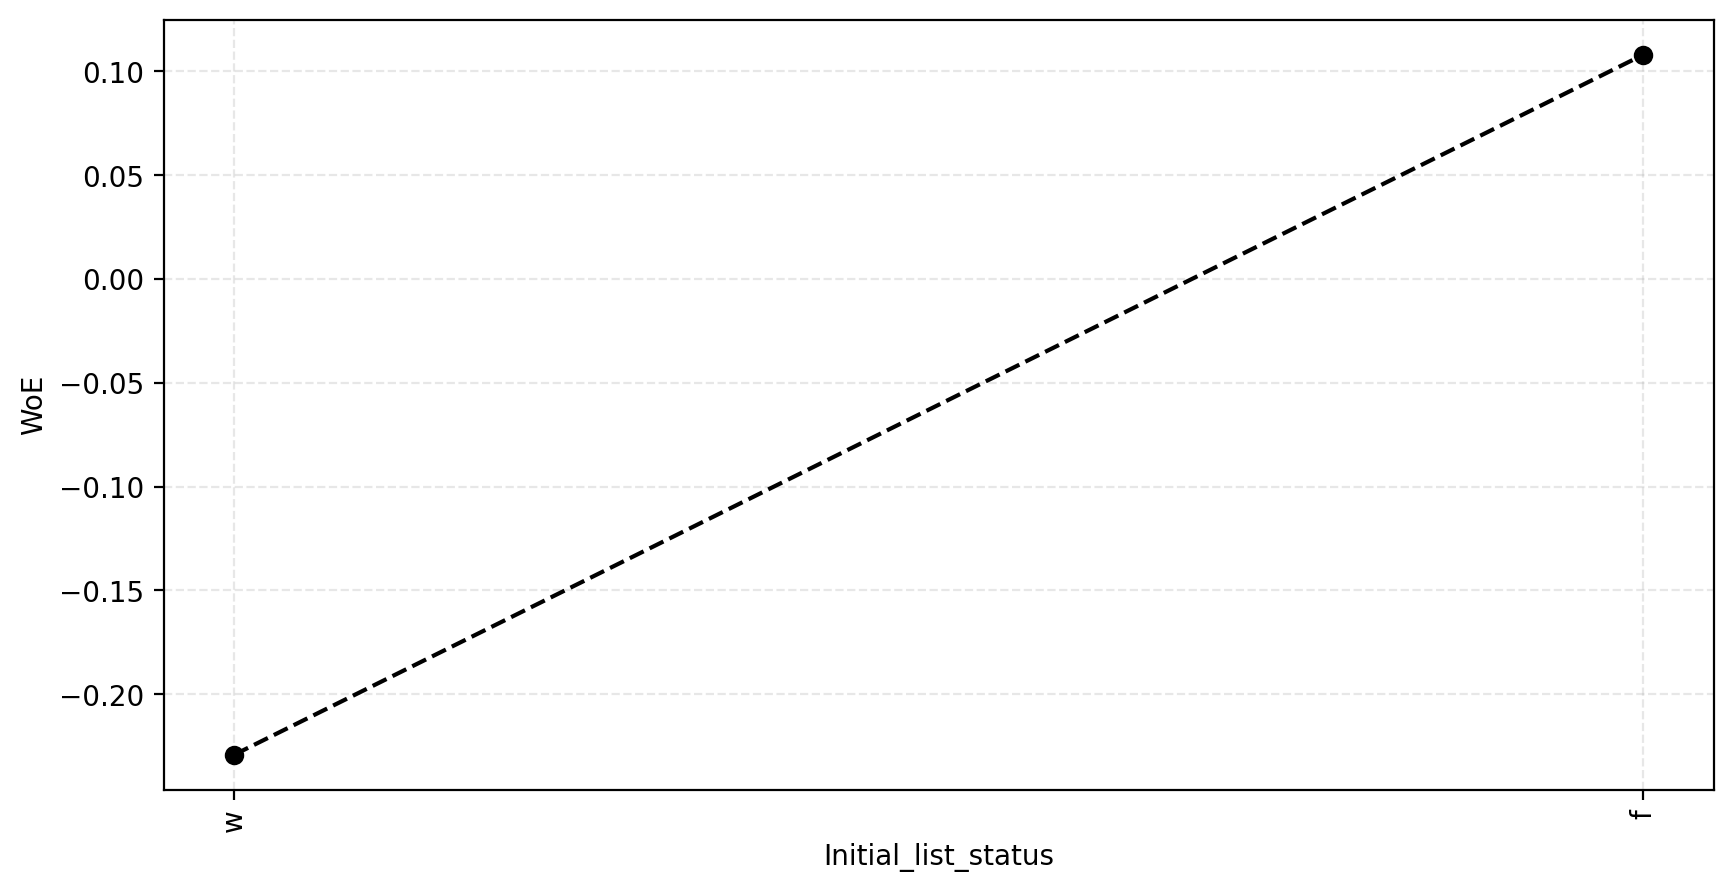

In [49]:
plot_woe_by_category(woe_df, rotate=True)

Since there are two categories, and only 2, we are good to go.

In [50]:
final_categories = {
    v: [v] for v in df_train[variable].unique()
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [51]:
df_train[filter(lambda x: x.startswith(variable), df_train.columns)].sum(axis=1).sum() == len(df_train)

True

In [52]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "f")

#### Numeric Features

It is time for us now to take a closer look at numeric variables. It is going to be pretty much similar to what we've accomplished so far for cstegorical variables. However, there is a slight difference - variables are continuous. Hence, we are going to rely on a two-stage strategy to convert them into an appropriate format:

**(1) Fine Classing**: Roughly groupping variables into categories (constant intervals, for instance);  
**(2) Coarse Classing**: Determining final categories by combining few of them into bigger ones.

We are going to analyze the following variables:

* `term`
* `emp_length`
* `months_since_issue_d`
* `int_rate`
* `funded_amnt`
* `months_since_earliest_cr_line`
* `annual_inc`
* `delinq_2yrs`
* `inq_last_6_mths`
* `open_acc`
* `pub_rec`
* `total_acc`
* `dti`
* `total_rev_hi_lim`

1. `term`

In [53]:
variable = "term"
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe())

0.00% missing!


count    373028.000000
mean         42.588953
std          10.710783
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: term, dtype: float64


In [54]:
print(df_train[variable].value_counts())

36    270617
60    102411
Name: term, dtype: int64


In this case we've only got 2 categories. Thus, let's keep them according to WoE analysis.

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
term,,,,,,,
36,244290,26327,270617,0.735251,0.645681,-0.129906,0.037738
60,87964,14447,102411,0.264749,0.354319,0.291414,0.037738


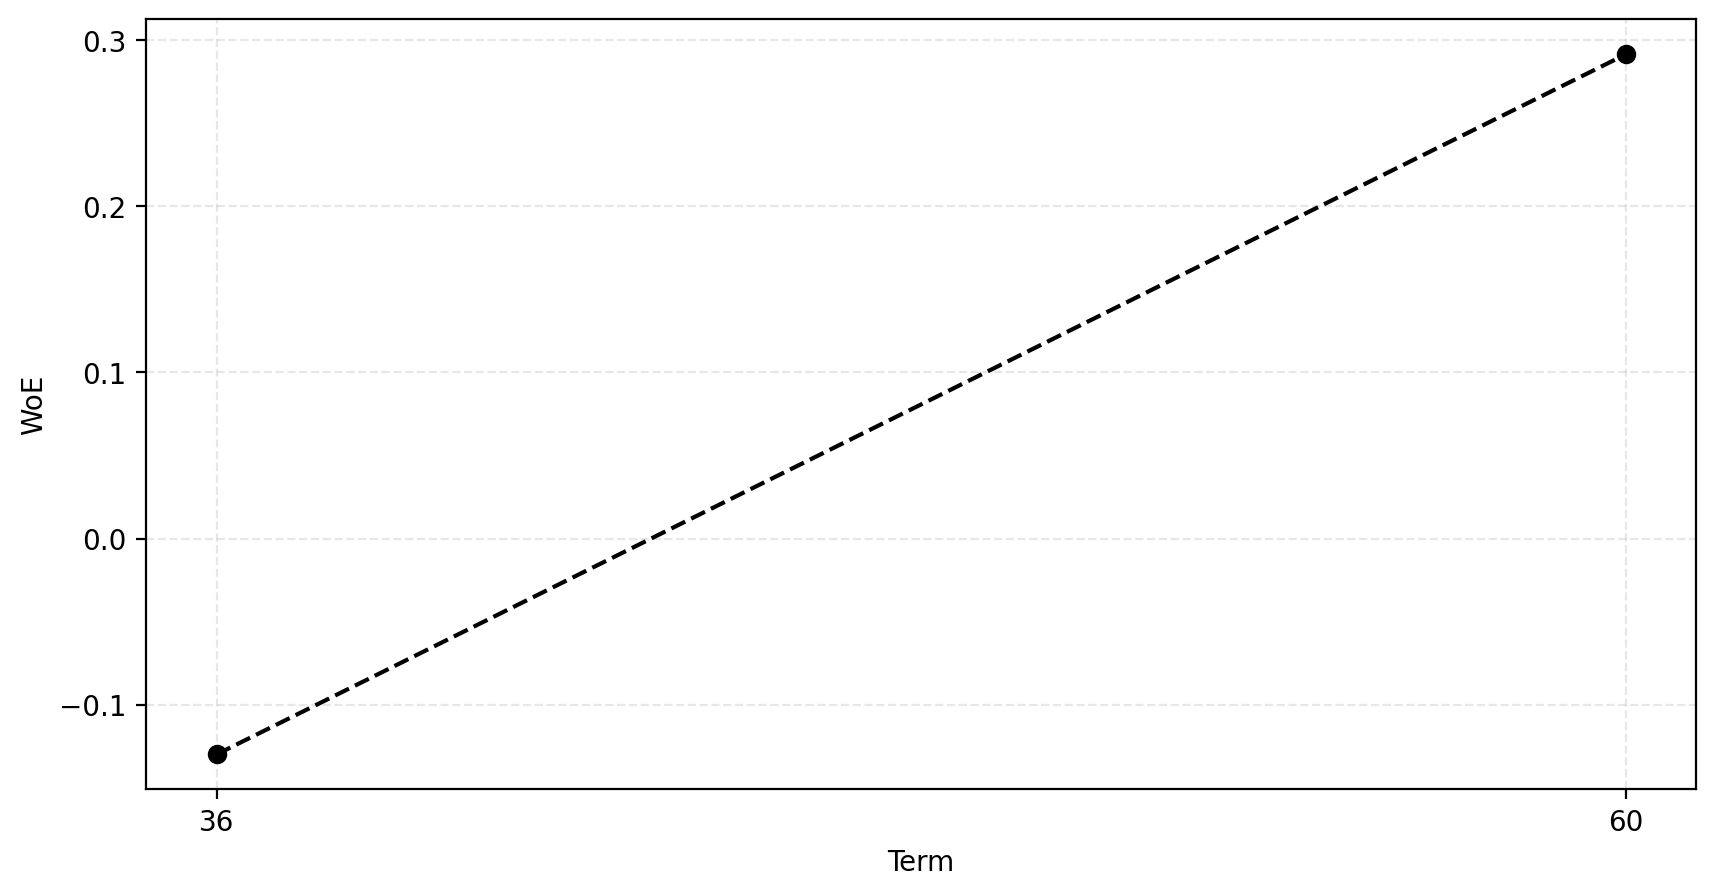

In [55]:
df_train[variable] = df_train[variable].astype(str)
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
)
display(woe_df)
plot_woe_by_category(woe_df)

In [56]:
final_categories = {
    v: [v] for v in df_train[variable].unique()
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [57]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "60")

2. `emp_length`

In [58]:
variable = "emp_length"
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].value_counts())

4.53% missing!


10    120251
2      33050
3      29323
0      28870
5      24627
1      23701
4      22462
6      20862
7      20847
8      17850
9      14296
Name: emp_length, dtype: int64


From the business perspective, the highest-risk scenario is someone with less 0y of employment. Hence, let's impute with this value.

In [59]:
df_train[variable] = df_train[variable].fillna(0)

Since we've only got 10 categories, let's proceed with the usual analysis

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
emp_length,,,,,,,
0,40083,5676,45759,0.120640,0.139206,0.143150,0.00665
1,21040,2661,23701,0.063325,0.065262,0.030132,0.00665
2,29421,3629,33050,0.088550,0.089003,0.005104,0.00665
3,26075,3248,29323,0.078479,0.079659,0.014918,0.00665
4,20053,2409,22462,0.060354,0.059082,-0.021312,0.00665
5,21799,2828,24627,0.065609,0.069358,0.055561,0.00665
6,18444,2418,20862,0.055512,0.059302,0.066057,0.00665
7,18521,2326,20847,0.055743,0.057046,0.023100,0.00665
8,15845,2005,17850,0.047689,0.049173,0.030645,0.00665


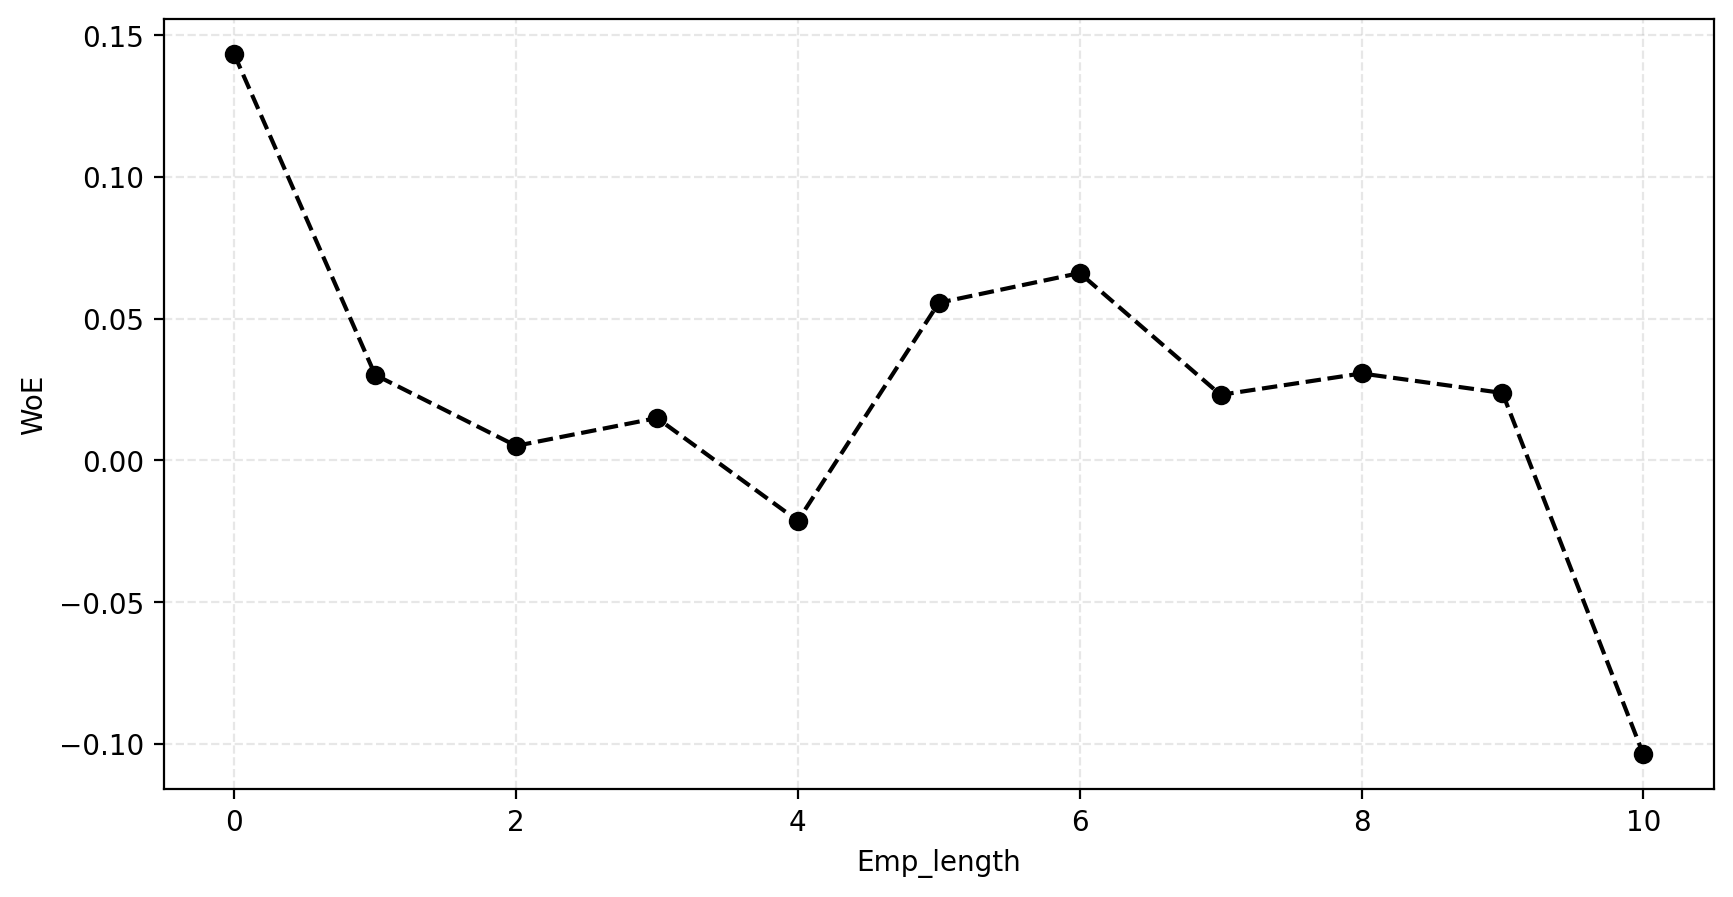

In [60]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=variable,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df)

From the visualization above, we can come up with the following final categories:

* `<1y`

* `1y`

* `2-4y`

* `5-6y`

* `7-9y`

* `10+y`

In [61]:
df_train[variable] = df_train[variable].astype(str)
final_categories = {
    "<1y": ["0"],
    "1y": ["1"],
    "2-4y": ["2", "3", "4"],
    "5-6y": ["5", "6", "7"],
    "7-9y": ["7", "8", "9"],
    "10+y": ["10"],
}

grade_ohe = OHECategoriesCreator(field_name=variable, final_categories_dict=final_categories)
df_train = grade_ohe.fit_transform(df_train)
transformers.append(grade_ohe)

In [62]:
features += [f"{variable}_{cat}" for cat in final_categories.keys()]
reference_categories.append(f"{variable}_" + "<1y")

3. `months_since_issue_d`

In [63]:
variable = "months_since_issue_d"
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe())

0.00% missing!


count    373028.000000
mean         50.947197
std          14.329935
min          36.000000
25%          41.000000
50%          46.000000
75%          57.000000
max         126.000000
Name: months_since_issue_d, dtype: float64


In [64]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=30
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
months_since_issue_d_categories,,,,,,,
"000. (35.91, 39.0]",63247,4403,67650,0.190357,0.107985,-0.566906,0.112637
"001. (39.0, 42.0]",47932,4400,52332,0.144263,0.107912,-0.290324,0.112637
"002. (42.0, 45.0]",50426,5442,55868,0.151769,0.133467,-0.128505,0.112637
"003. (45.0, 48.0]",32563,3793,36356,0.098006,0.093025,-0.052164,0.112637
"004. (48.0, 51.0]",19140,2544,21684,0.057607,0.062393,0.079812,0.112637
"005. (51.0, 54.0]",24691,3618,28309,0.074314,0.088733,0.177338,0.112637
"006. (54.0, 57.0]",24537,3969,28506,0.073850,0.097341,0.276187,0.112637
"007. (57.0, 60.0]",13226,2251,15477,0.039807,0.055207,0.327045,0.112637
"008. (60.0, 63.0]",8465,1461,9926,0.025477,0.035832,0.341036,0.112637


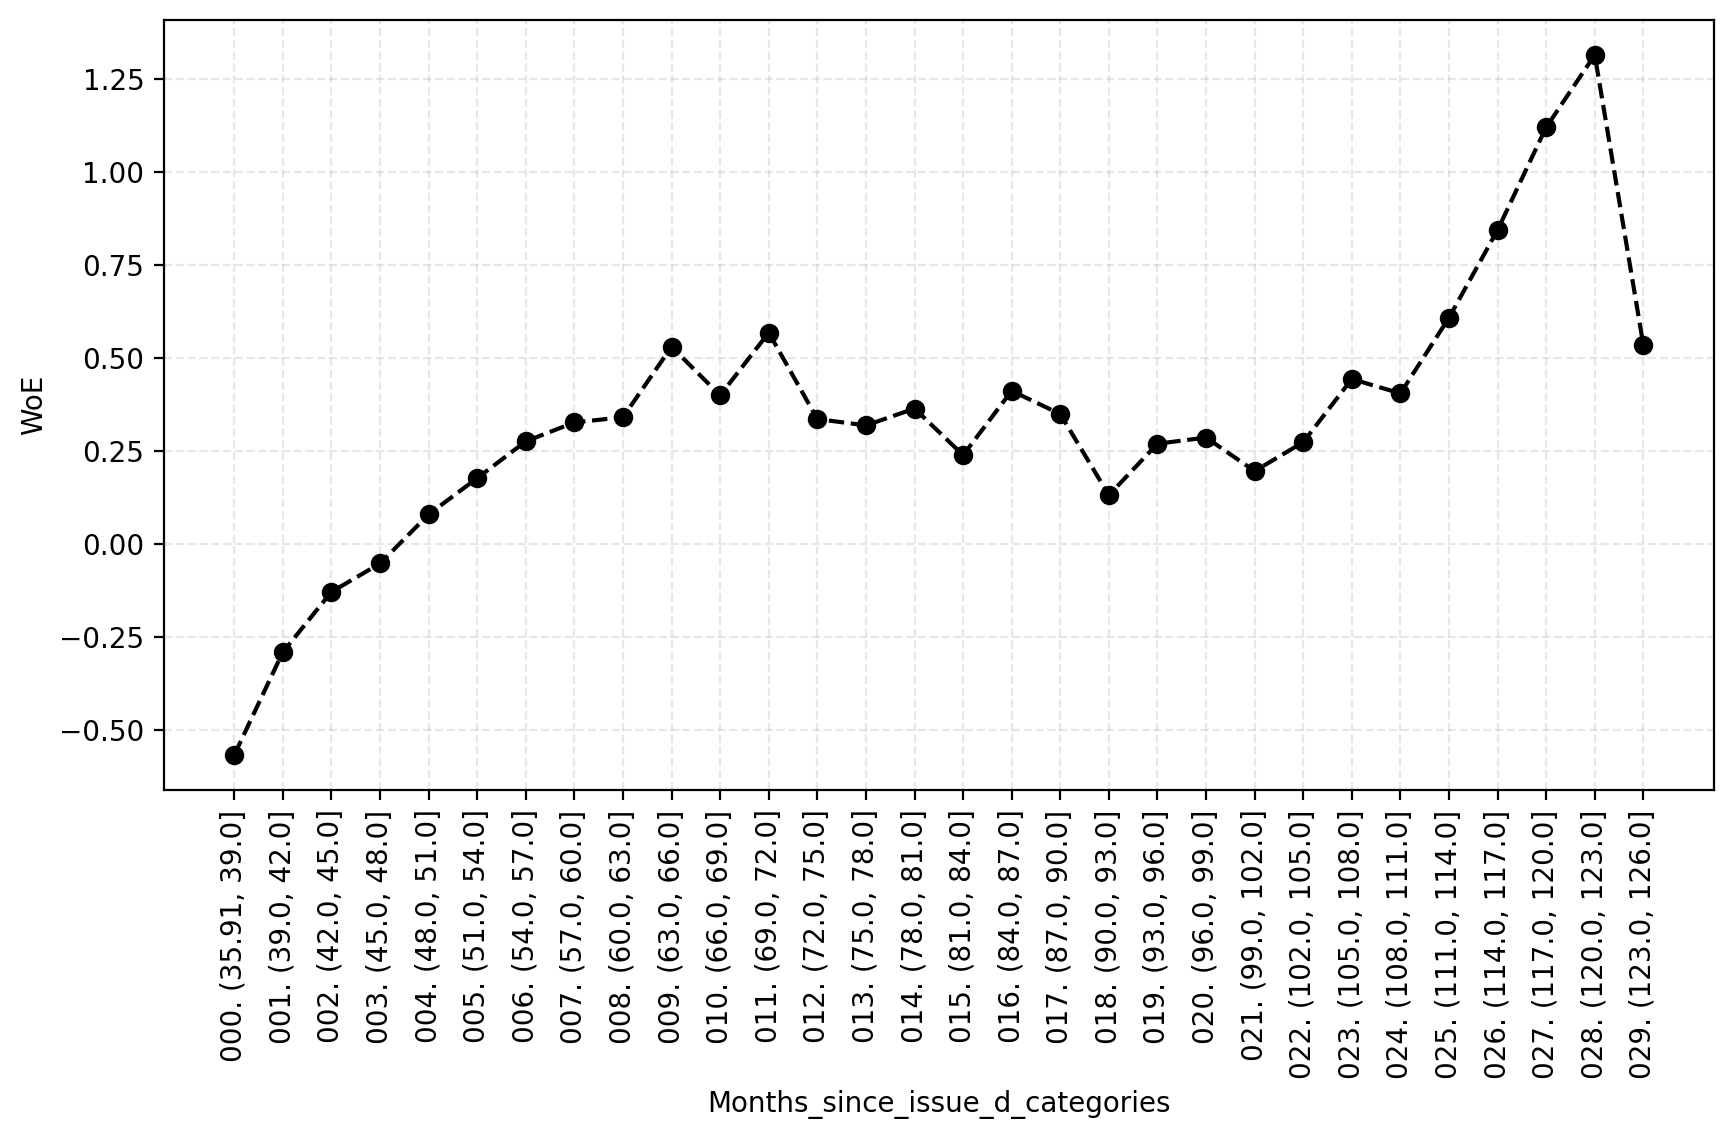

In [65]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [66]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    39,
    42,
    45,
    48,
    51,
    54,
    63,
    84,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [67]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "85-127")

4. `int_rate`

In [68]:
variable = "int_rate"
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe())

0.00% missing!


count    373028.000000
mean         13.830330
std           4.353664
min           5.420000
25%          10.990000
50%          13.660000
75%          16.490000
max          26.060000
Name: int_rate, dtype: float64


In [69]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=30
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
int_rate_categories,,,,,,,
"000. (5.399, 6.108]",8776,191,8967,0.026414,0.004684,-1.729647,0.339226
"001. (6.108, 6.796]",7965,237,8202,0.023973,0.005813,-1.416897,0.339226
"002. (6.796, 7.484]",4699,127,4826,0.014143,0.003115,-1.513063,0.339226
"003. (7.484, 8.172]",19920,918,20838,0.059954,0.022514,-0.979427,0.339226
"004. (8.172, 8.86]",7796,248,8044,0.023464,0.006082,-1.350082,0.339226
"005. (8.86, 9.548]",15372,791,16163,0.046266,0.019400,-0.869150,0.339226
"006. (9.548, 10.236]",16516,1148,17664,0.049709,0.028155,-0.568453,0.339226
"007. (10.236, 10.924]",6014,603,6617,0.018101,0.014789,-0.202073,0.339226
"008. (10.924, 11.612]",21146,1632,22778,0.063644,0.040026,-0.463789,0.339226


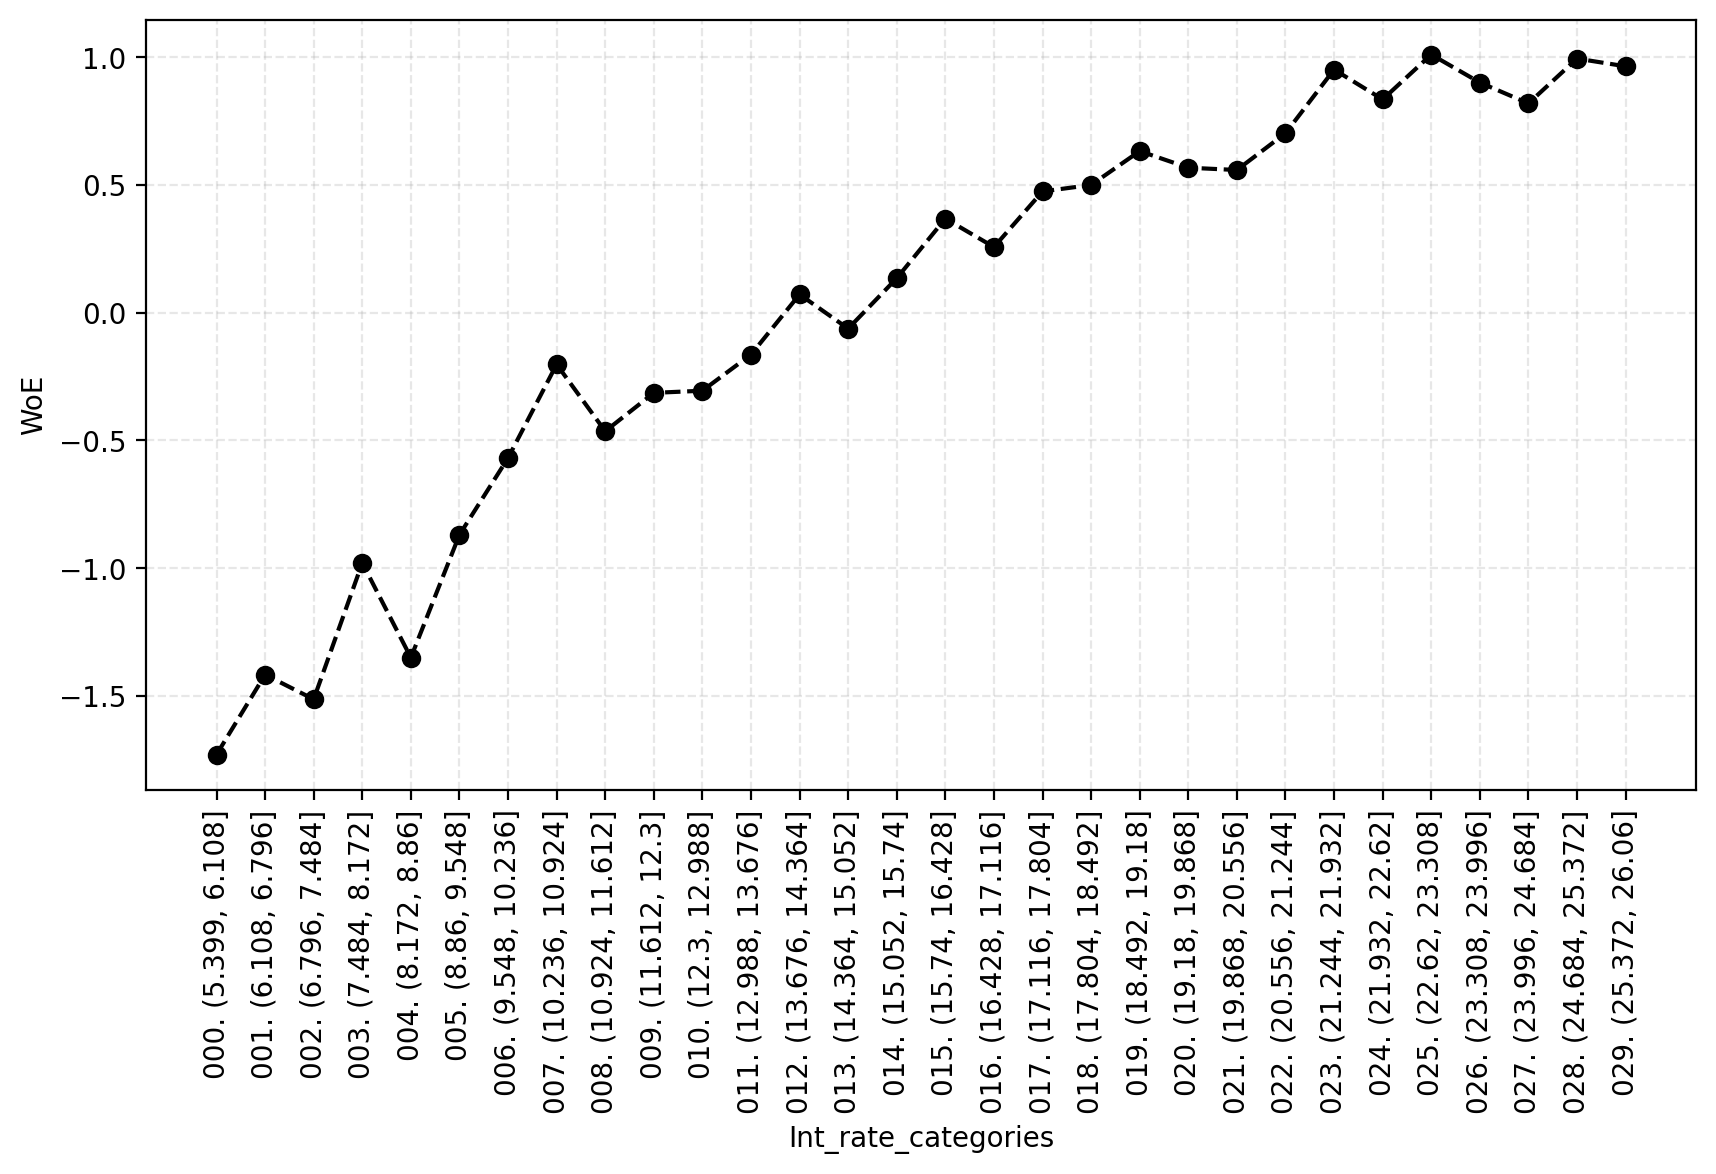

In [70]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [71]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    6.00,
    7.50,
    8.90,
    9.50,
    10.20,
    13.70,
    15.70,
    17.10,
    20.50,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [72]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "21.5-27")

5. `funded_amnt`

In [73]:
variable = "funded_amnt"
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe())

0.00% missing!


count    373028.000000
mean      14289.637641
std        8275.754748
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: funded_amnt, dtype: float64


In [74]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=30
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
funded_amnt_categories,,,,,,,
"000. (465.5, 1650.0]",3265,378,3643,0.009827,0.009271,-0.058266,0.006376
"001. (1650.0, 2800.0]",7041,846,7887,0.021192,0.020749,-0.021131,0.006376
"002. (2800.0, 3950.0]",9676,1185,10861,0.029122,0.029063,-0.002051,0.006376
"003. (3950.0, 5100.0]",21340,2543,23883,0.064228,0.062368,-0.029384,0.006376
"004. (5100.0, 6250.0]",18090,1973,20063,0.054446,0.048389,-0.117949,0.006376
"005. (6250.0, 7400.0]",15188,1740,16928,0.045712,0.042674,-0.068765,0.006376
"006. (7400.0, 8550.0]",20409,2416,22825,0.061426,0.059253,-0.036008,0.006376
"007. (8550.0, 9700.0]",12867,1671,14538,0.038726,0.040982,0.056611,0.006376
"008. (9700.0, 10850.0]",31899,3956,35855,0.096008,0.097023,0.010514,0.006376


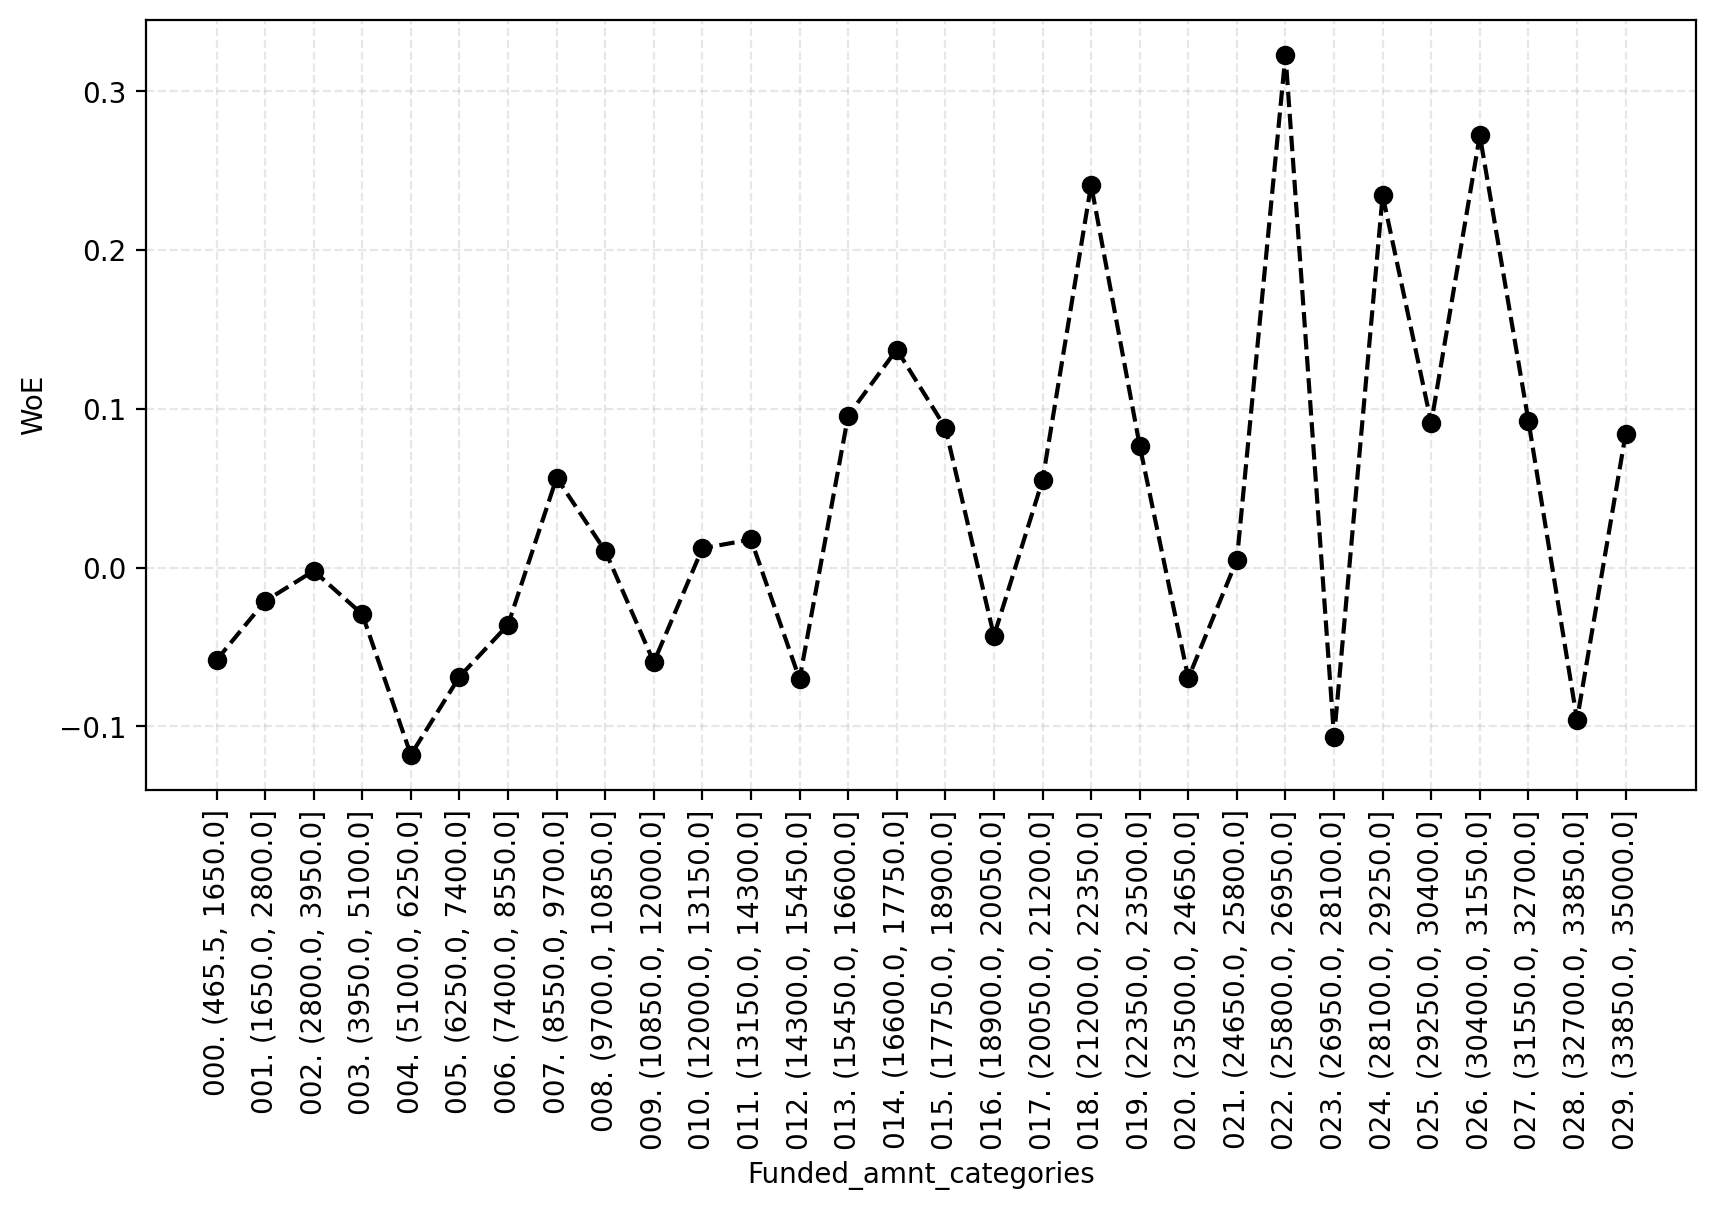

In [75]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

For this variable, there is clearly no association whatsoever. Hence, we won't even use it for model development.

6. `months_since_earliest_cr_line`

In [76]:
variable = "months_since_earliest_cr_line"
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe())

0.00% missing!


count    373028.000000
mean        242.058384
std          86.385967
min          73.000000
25%         184.000000
50%         225.000000
75%         285.000000
max         586.000000
Name: months_since_earliest_cr_line, dtype: float64


In [77]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=30
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
months_since_earliest_cr_line_categories,,,,,,,
"000. (72.487, 90.1]",1950,215,2165,0.005869,0.005273,-0.107092,0.01547
"001. (90.1, 107.2]",3513,570,4083,0.010573,0.013979,0.279266,0.01547
"002. (107.2, 124.3]",8232,1263,9495,0.024776,0.030976,0.223316,0.01547
"003. (124.3, 141.4]",15259,2325,17584,0.045926,0.057022,0.216406,0.01547
"004. (141.4, 158.5]",18380,2518,20898,0.055319,0.061755,0.110057,0.01547
"005. (158.5, 175.6]",22015,2879,24894,0.066260,0.070609,0.063574,0.01547
"006. (175.6, 192.7]",29473,3895,33368,0.088706,0.095527,0.074074,0.01547
"007. (192.7, 209.8]",34330,4337,38667,0.103325,0.106367,0.029018,0.01547
"008. (209.8, 226.9]",34292,4474,38766,0.103210,0.109727,0.061226,0.01547


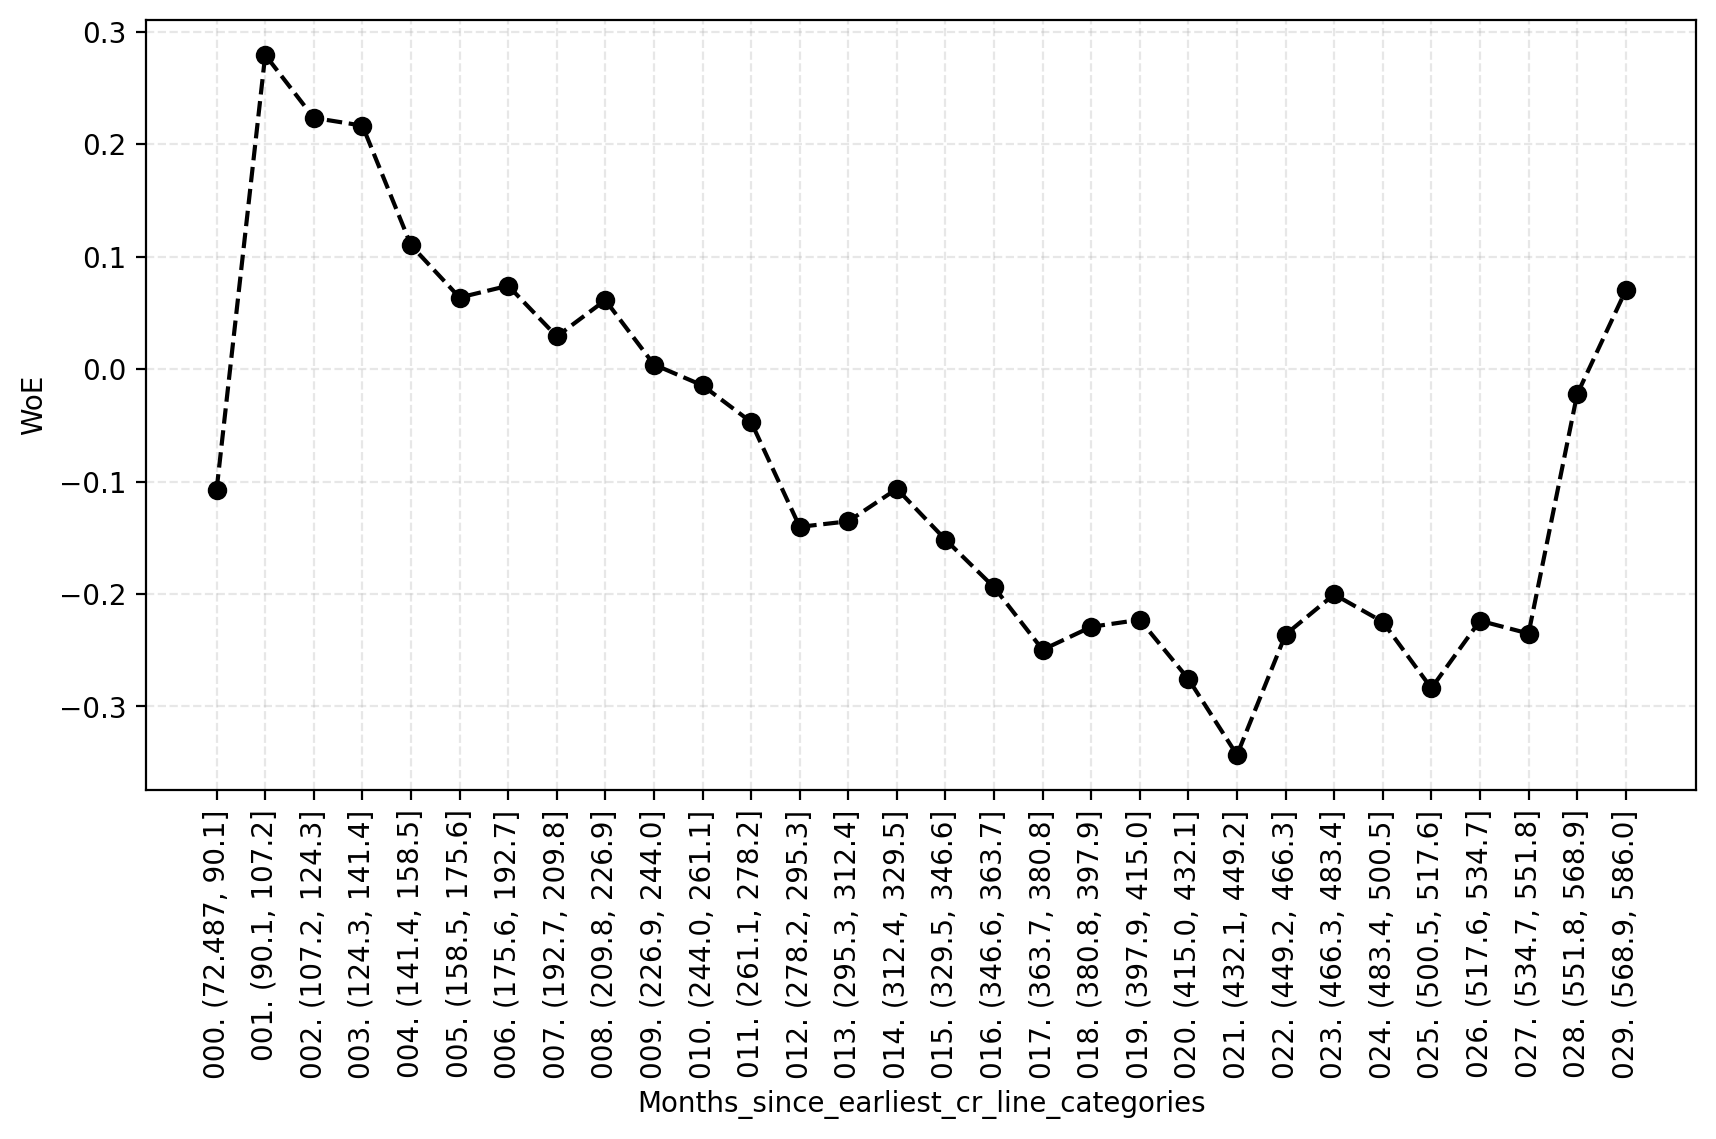

In [78]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [79]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    140,
    220,
    280,
    360,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [80]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "72-140")

7. `annual_inc`

In [81]:
variable = "annual_inc"
df_train[variable] = df_train[variable].fillna(df_train[variable].min())
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95]))

0.00% missing!


count    3.730280e+05
mean     7.331241e+04
std      5.570830e+04
min      2.000000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      8.900000e+04
90%      1.200000e+05
95%      1.500000e+05
max      7.500000e+06
Name: annual_inc, dtype: float64


We can see that this variable has a highly skewed distribution. Hence, let's winsorize values, based on the 95th percentile ($150k). From a business perspective, it also makes sense, as wealthy people should get the same treatment.

In [82]:
winsorizer = NumericWinsorizer(
    field_name=variable, upper=140_000
)
df_train = winsorizer.transform(df_train)
transformers.append(winsorizer)

In [83]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=30
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
annual_inc_categories,,,,,,,
"000. (1862.0, 6600.0]",31,9,40,0.000093,0.000221,0.861092,0.055837
"001. (6600.0, 11200.0]",375,68,443,0.001129,0.001668,0.390437,0.055837
"002. (11200.0, 15800.0]",1329,277,1606,0.004000,0.006794,0.529691,0.055837
"003. (15800.0, 20400.0]",3202,541,3743,0.009637,0.013268,0.319743,0.055837
"004. (20400.0, 25000.0]",6979,1232,8211,0.021005,0.030215,0.363588,0.055837
"005. (25000.0, 29600.0]",6717,1148,7865,0.020216,0.028155,0.331235,0.055837
"006. (29600.0, 34200.0]",14698,2383,17081,0.044237,0.058444,0.278504,0.055837
"007. (34200.0, 38800.0]",16672,2659,19331,0.050178,0.065213,0.262075,0.055837
"008. (38800.0, 43400.0]",22533,3451,25984,0.067819,0.084637,0.221538,0.055837


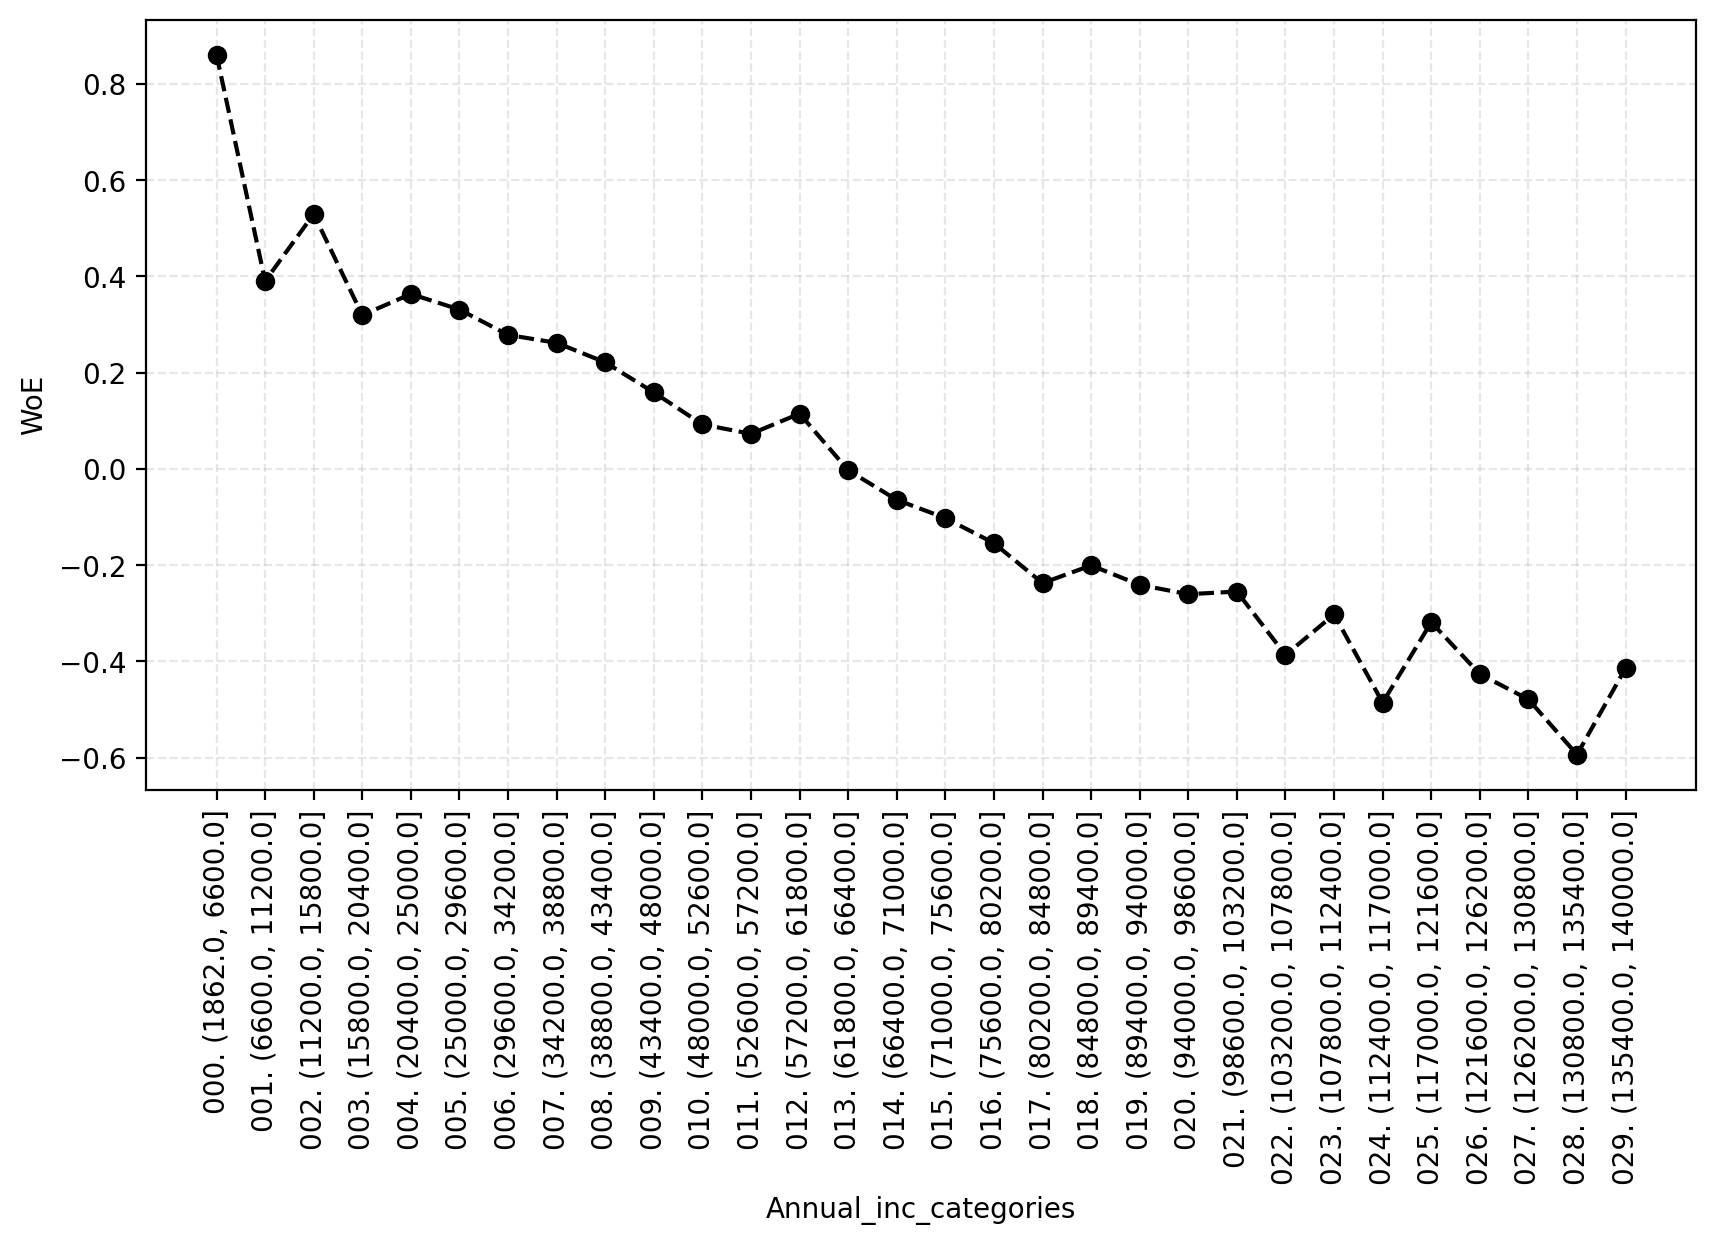

In [84]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [85]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    20_000,
    30_000,
    40_000,
    50_000,
    60_000,
    70_000,
    80_000,
    90_000,
    100_000,
    120_000,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [86]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "1862-20000")

8. `delinq_2yrs`

In [87]:
variable = "delinq_2yrs"
df_train[variable] = df_train[variable].fillna(df_train[variable].max())
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95, 0.999]))

0.00% missing!


count    373028.000000
mean          0.286866
std           0.827162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           1.000000
95%           2.000000
99.9%         8.000000
max          29.000000
Name: delinq_2yrs, dtype: float64


We can see that this variable has a highly skewed distribution. Hence, let's winsorize values, based on the 99.9th percentile (8).

In [88]:
winsorizer = NumericWinsorizer(
    field_name=variable, upper=8
)
df_train = winsorizer.transform(df_train)
transformers.append(winsorizer)

In [89]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=4
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
delinq_2yrs_categories,,,,,,,
"000. (-0.008, 2.0]",324607,39790,364397,0.976984,0.975867,-0.001144,0.000061
"001. (2.0, 4.0]",5718,734,6452,0.017210,0.018002,0.044990,0.000061
"002. (4.0, 6.0]",1319,167,1486,0.003970,0.004096,0.031220,0.000061
"003. (6.0, 8.0]",610,83,693,0.001836,0.002036,0.103237,0.000061


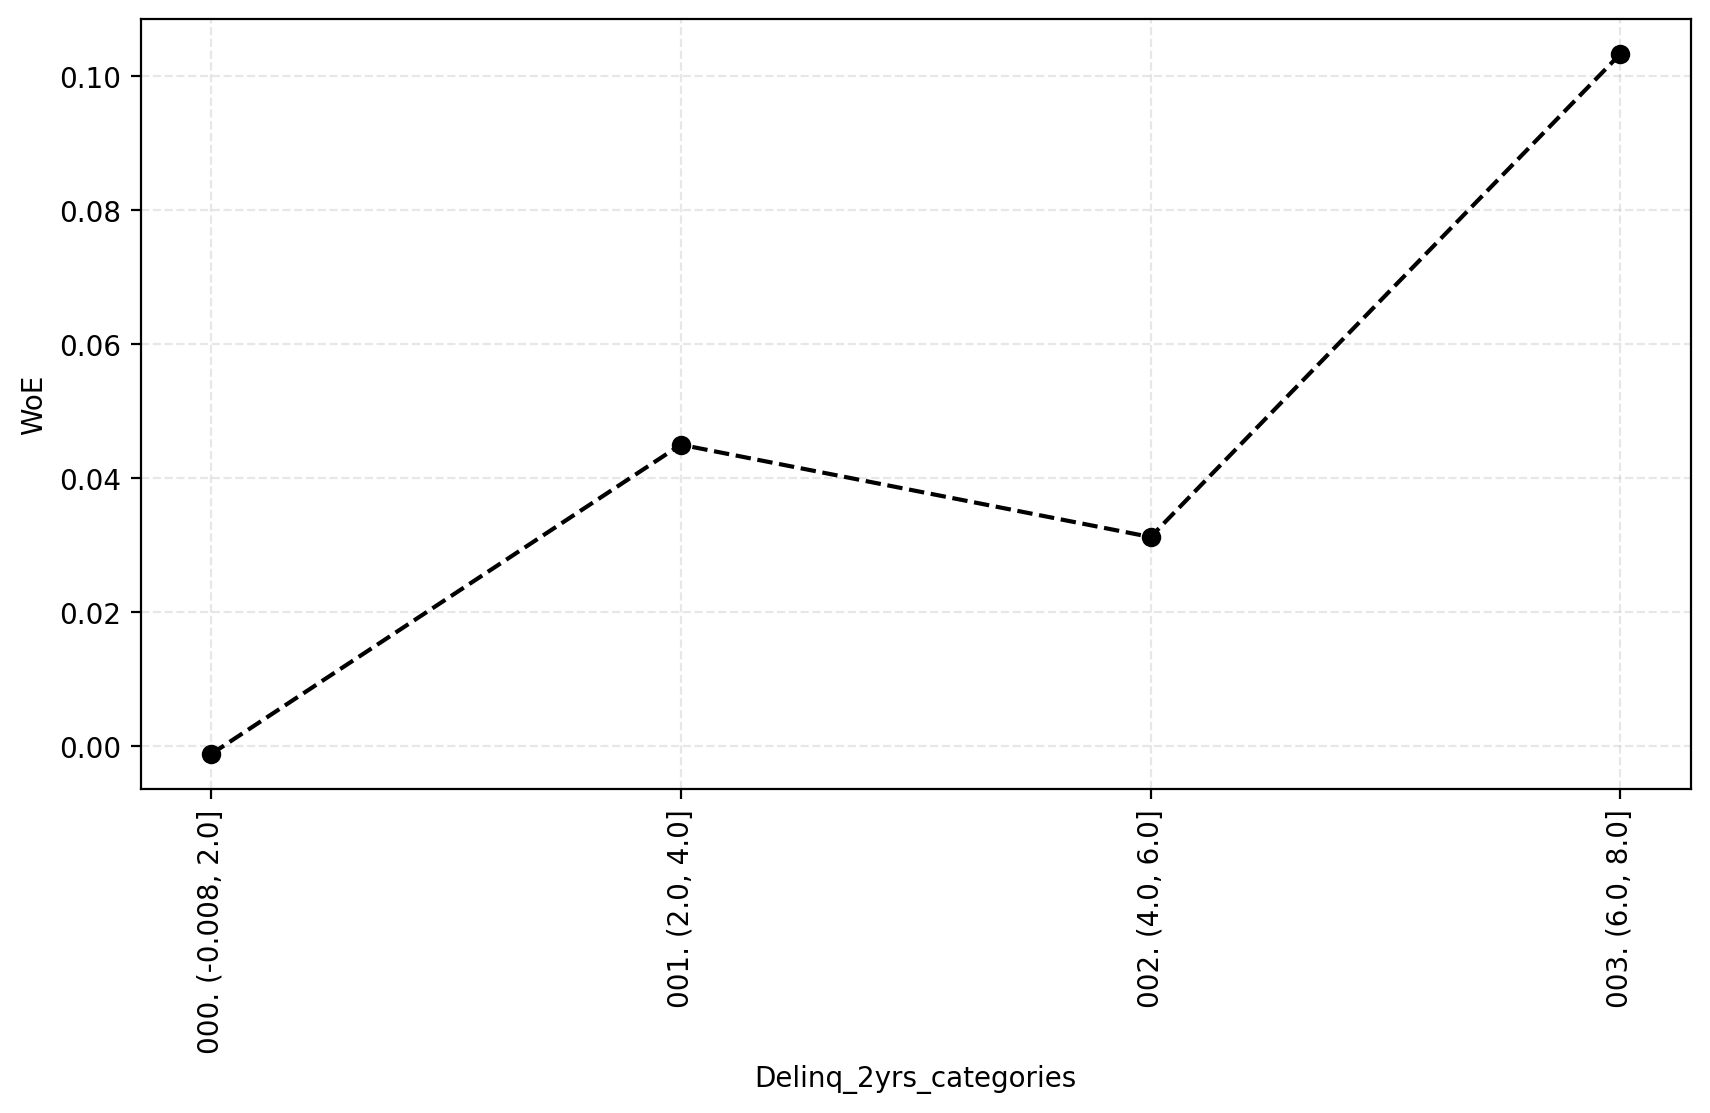

In [90]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [91]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    0,
    2,
    4,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [92]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "5-9")

9. `inq_last_6mths`

In [93]:
variable = "inq_last_6mths"
df_train[variable] = df_train[variable].fillna(df_train[variable].max())
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95, 0.999]))

0.00% missing!


count    373028.000000
mean          0.807248
std           1.118356
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
90%           2.000000
95%           3.000000
99.9%         7.000000
max          33.000000
Name: inq_last_6mths, dtype: float64


We can see that this variable has a highly skewed distribution. Hence, let's winsorize values, based on the 99.9th percentile (7).

In [94]:
winsorizer = NumericWinsorizer(
    field_name=variable, upper=7
)
df_train = winsorizer.transform(df_train)
transformers.append(winsorizer)

In [95]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=7
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
inq_last_6mths_categories,,,,,,,
"000. (-0.007, 1.0]",267608,29658,297266,0.805432,0.727375,-0.101936,0.039047
"001. (1.0, 2.0]",39976,6310,46286,0.120318,0.154755,0.251712,0.039047
"002. (2.0, 3.0]",16936,3189,20125,0.050973,0.078212,0.428121,0.039047
"003. (3.0, 4.0]",4872,900,5772,0.014663,0.022073,0.408990,0.039047
"004. (4.0, 5.0]",1851,378,2229,0.005571,0.009271,0.509268,0.039047
"005. (5.0, 6.0]",756,205,961,0.002275,0.005028,0.792824,0.039047
"006. (6.0, 7.0]",255,134,389,0.000767,0.003286,1.454431,0.039047


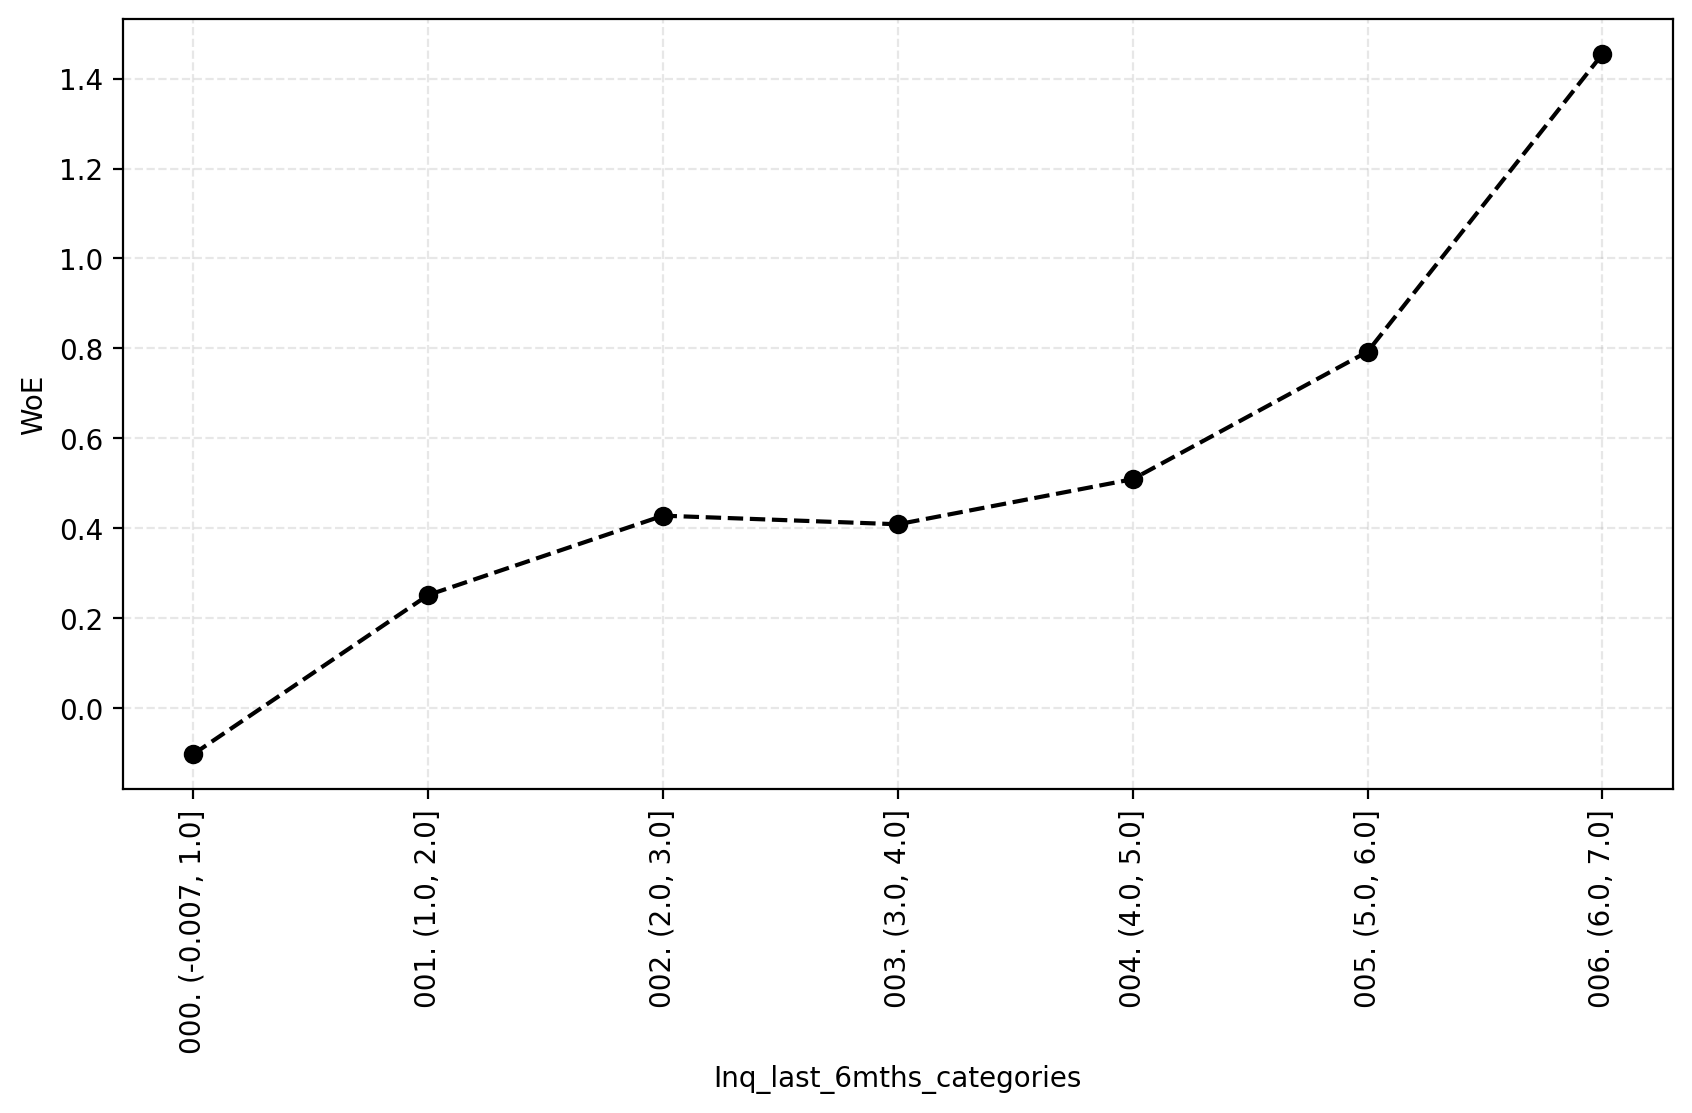

In [96]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [97]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    0,
    1,
    2,
    4,
    5,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [98]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "6-8")

10. `open_acc`

In [99]:
variable = "open_acc"
df_train[variable] = df_train[variable].fillna(df_train[variable].min())
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95, 0.999]))

0.00% missing!


count    373028.000000
mean         11.184246
std           4.991973
min           0.000000
25%           8.000000
50%          10.000000
75%          14.000000
90%          18.000000
95%          20.000000
99.9%        36.000000
max          84.000000
Name: open_acc, dtype: float64


We can see that this variable has a highly skewed distribution. Hence, let's winsorize values, based on the 95th percentile (20).

In [100]:
winsorizer = NumericWinsorizer(
    field_name=variable, upper=20
)
df_train = winsorizer.transform(df_train)
transformers.append(winsorizer)

In [101]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=20
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
open_acc_categories,,,,,,,
"000. (-0.02, 1.0]",114,17,131,0.000343,0.000417,0.194870,0.001825
"001. (1.0, 2.0]",1217,226,1443,0.003663,0.005543,0.414246,0.001825
"002. (2.0, 3.0]",3829,573,4402,0.011524,0.014053,0.198382,0.001825
"003. (3.0, 4.0]",8994,1076,10070,0.027070,0.026389,-0.025452,0.001825
"004. (4.0, 5.0]",15429,1869,17298,0.046437,0.045838,-0.012990,0.001825
"005. (5.0, 6.0]",22026,2708,24734,0.066293,0.066415,0.001842,0.001825
"006. (6.0, 7.0]",26676,3317,29993,0.080288,0.081351,0.013152,0.001825
"007. (7.0, 8.0]",29943,3625,33568,0.090121,0.088905,-0.013586,0.001825
"008. (8.0, 9.0]",31314,3920,35234,0.094247,0.096140,0.019881,0.001825


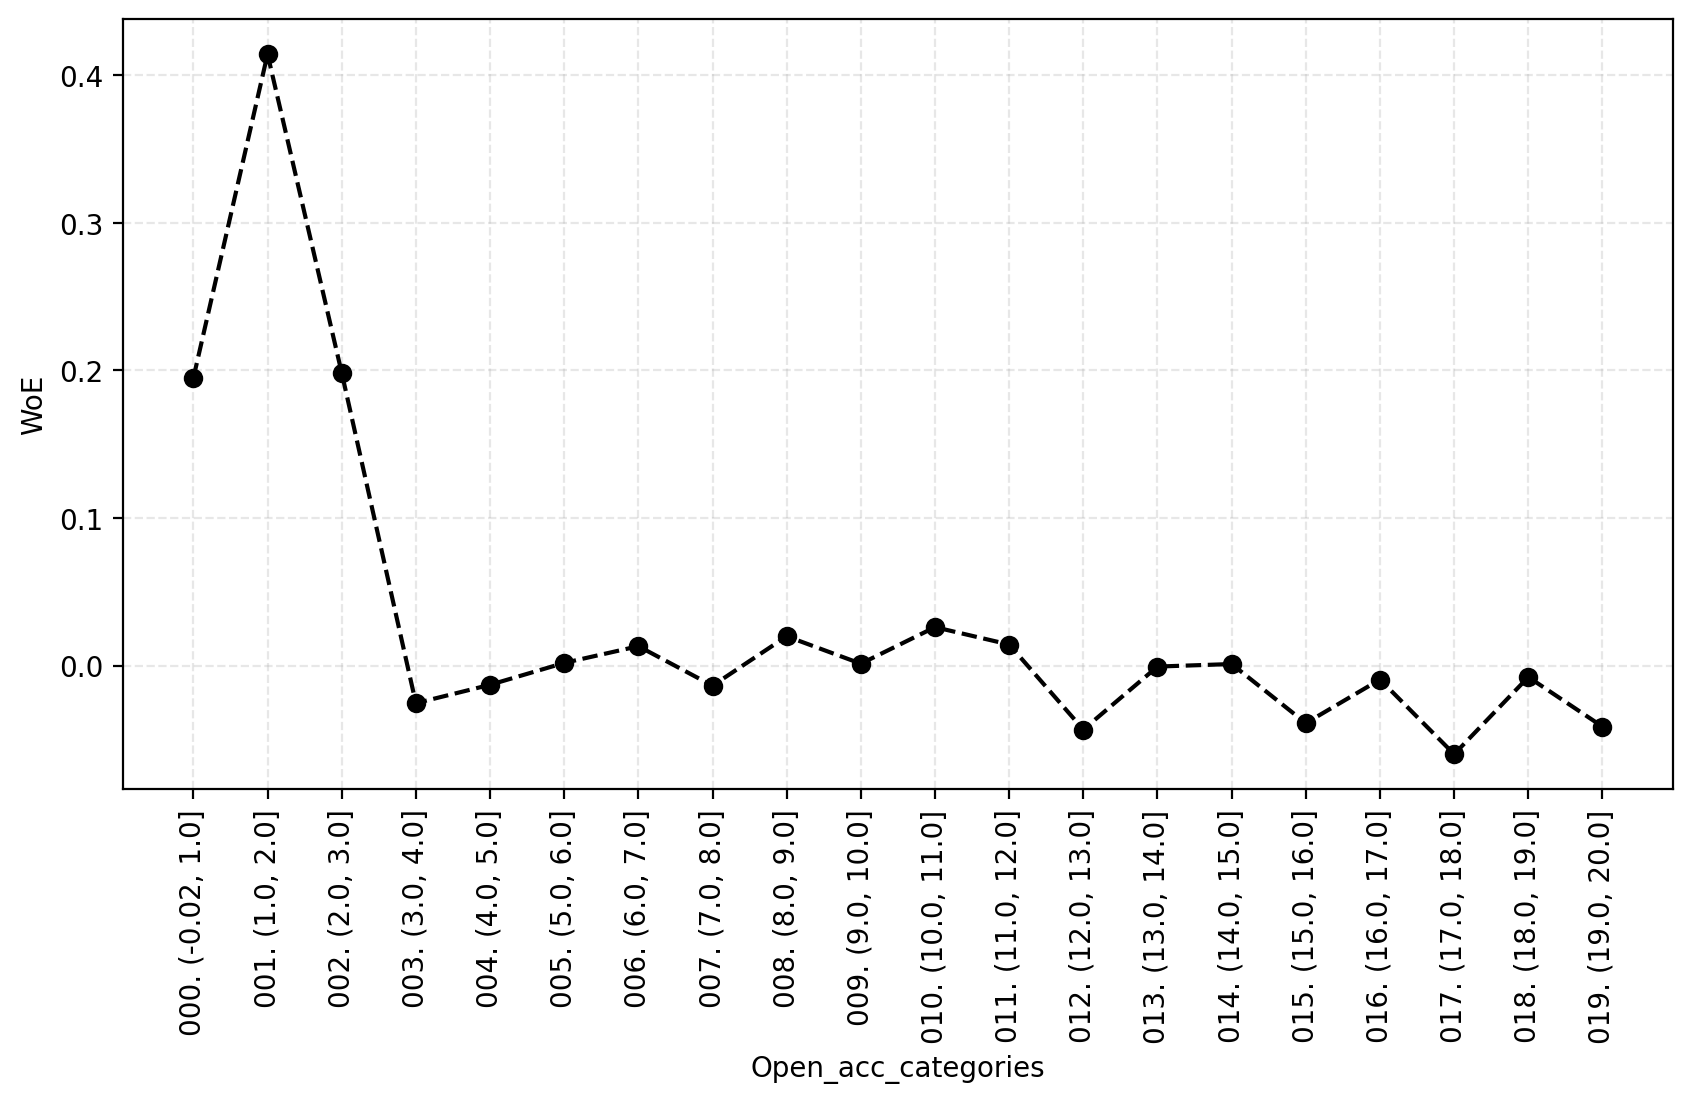

In [102]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [103]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    2,
    10,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [104]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "0-2")

11. `pub_rec`

In [105]:
variable = "pub_rec"
df_train[variable] = df_train[variable].fillna(df_train[variable].min())
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95, 0.999]))

0.00% missing!


count    373028.000000
mean          0.160854
std           0.514394
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           1.000000
95%           1.000000
99.9%         5.000000
max          63.000000
Name: pub_rec, dtype: float64


We can see that this variable has a highly skewed distribution. Hence, let's winsorize values, based on the 95th percentile (5).

In [106]:
winsorizer = NumericWinsorizer(
    field_name=variable, upper=5
)
df_train = winsorizer.transform(df_train)
transformers.append(winsorizer)

In [107]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=5
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
pub_rec_categories,,,,,,,
"000. (-0.005, 1.0]",326215,40159,366374,0.981824,0.984917,0.003145,0.000948
"001. (1.0, 2.0]",4059,446,4505,0.012217,0.010938,-0.110518,0.000948
"002. (2.0, 3.0]",1182,100,1282,0.003558,0.002453,-0.371938,0.000948
"003. (3.0, 4.0]",383,42,425,0.001153,0.001030,-0.112510,0.000948
"004. (4.0, 5.0]",415,27,442,0.001249,0.000662,-0.634587,0.000948


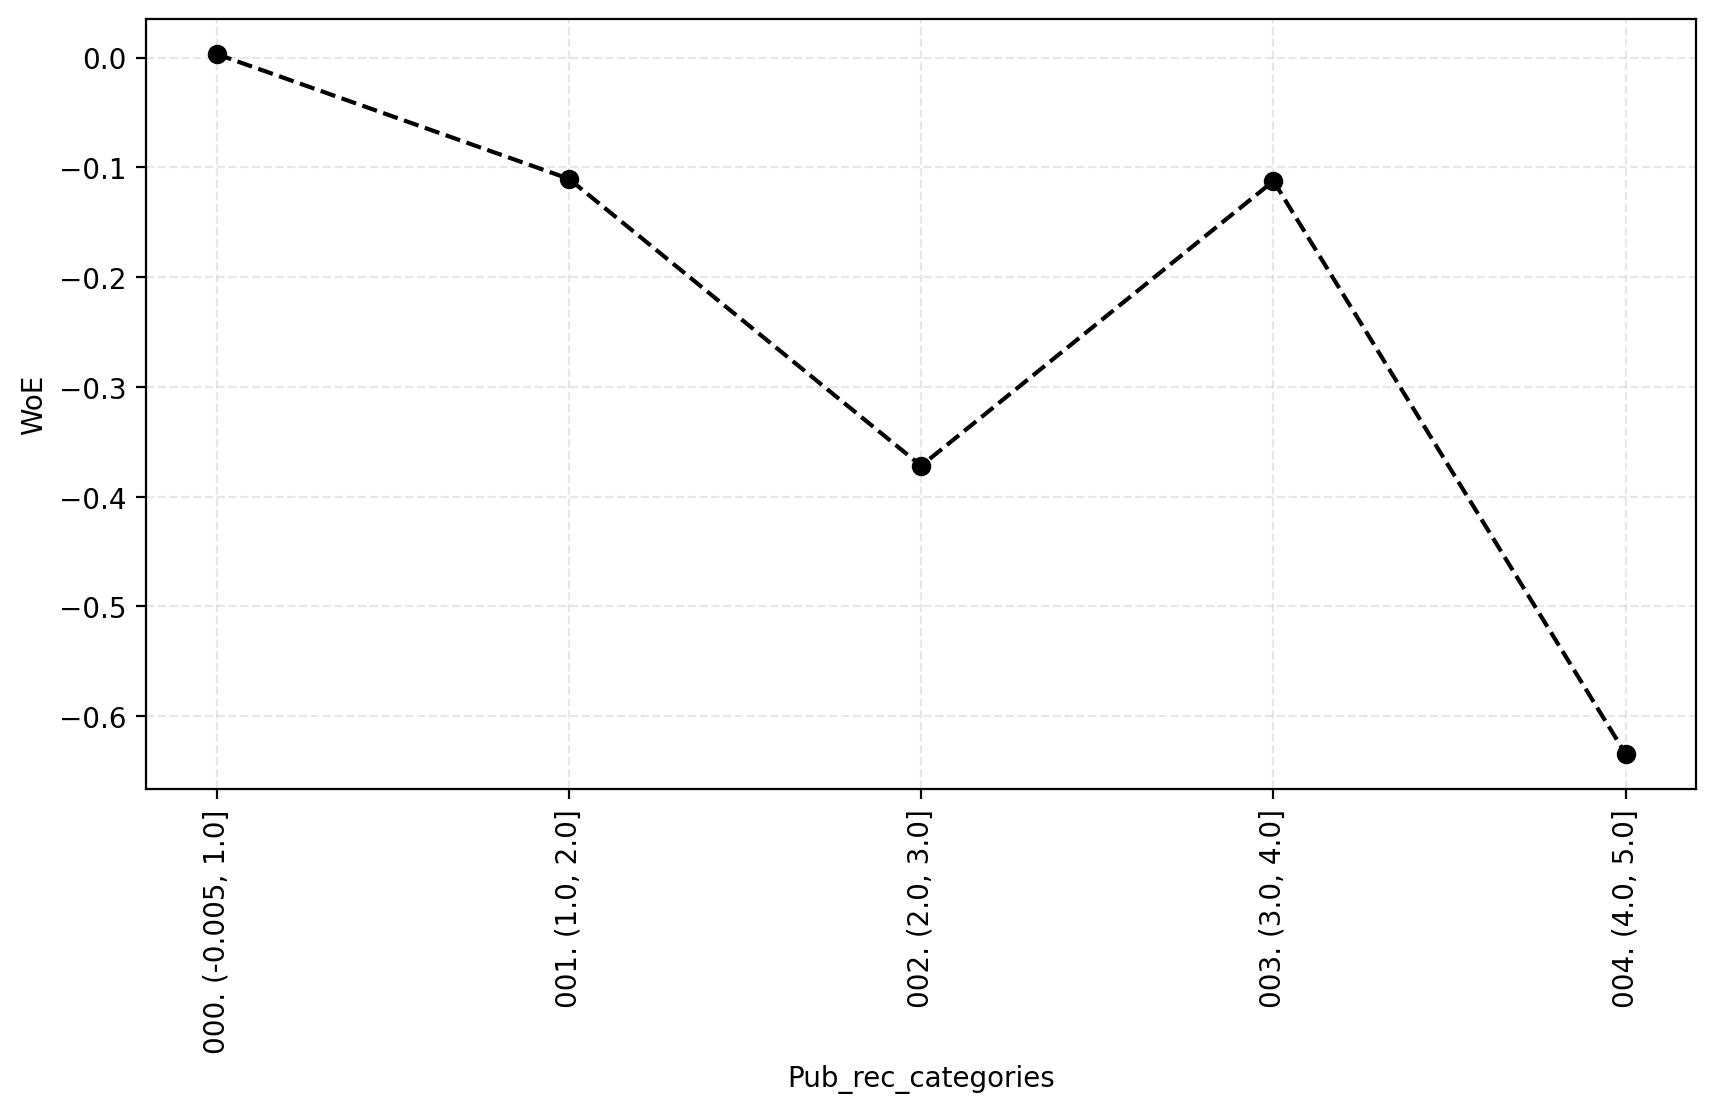

In [108]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [109]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    1,
    3,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [110]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "0-1")

12. `total_acc`

In [111]:
variable = "total_acc"
df_train[variable] = df_train[variable].fillna(df_train[variable].min())
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95, 0.999]))

0.00% missing!


count    373028.000000
mean         25.073954
std          11.617378
min           1.000000
25%          17.000000
50%          23.000000
75%          32.000000
90%          41.000000
95%          47.000000
99.9%        72.000000
max         156.000000
Name: total_acc, dtype: float64


We can see that this variable has a highly skewed distribution. Hence, let's winsorize values, based on the 95th percentile (47).

In [112]:
winsorizer = NumericWinsorizer(
    field_name=variable, upper=47
)
df_train = winsorizer.transform(df_train)
transformers.append(winsorizer)

In [113]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=30
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
total_acc_categories,,,,,,,
"000. (0.954, 2.533]",67,17,84,0.000202,0.000417,0.726376,0.007985
"001. (2.533, 4.067]",1331,257,1588,0.004006,0.006303,0.453245,0.007985
"002. (4.067, 5.6]",1636,263,1899,0.004924,0.006450,0.270000,0.007985
"003. (5.6, 7.133]",5891,899,6790,0.017730,0.022048,0.217957,0.007985
"004. (7.133, 8.667]",4389,632,5021,0.013210,0.015500,0.159888,0.007985
"005. (8.667, 10.2]",11781,1653,13434,0.035458,0.040541,0.133959,0.007985
"006. (10.2, 11.733]",7481,1000,8481,0.022516,0.024525,0.085489,0.007985
"007. (11.733, 13.267]",17385,2376,19761,0.052324,0.058272,0.107666,0.007985
"008. (13.267, 14.8]",9886,1310,11196,0.029754,0.032128,0.076763,0.007985


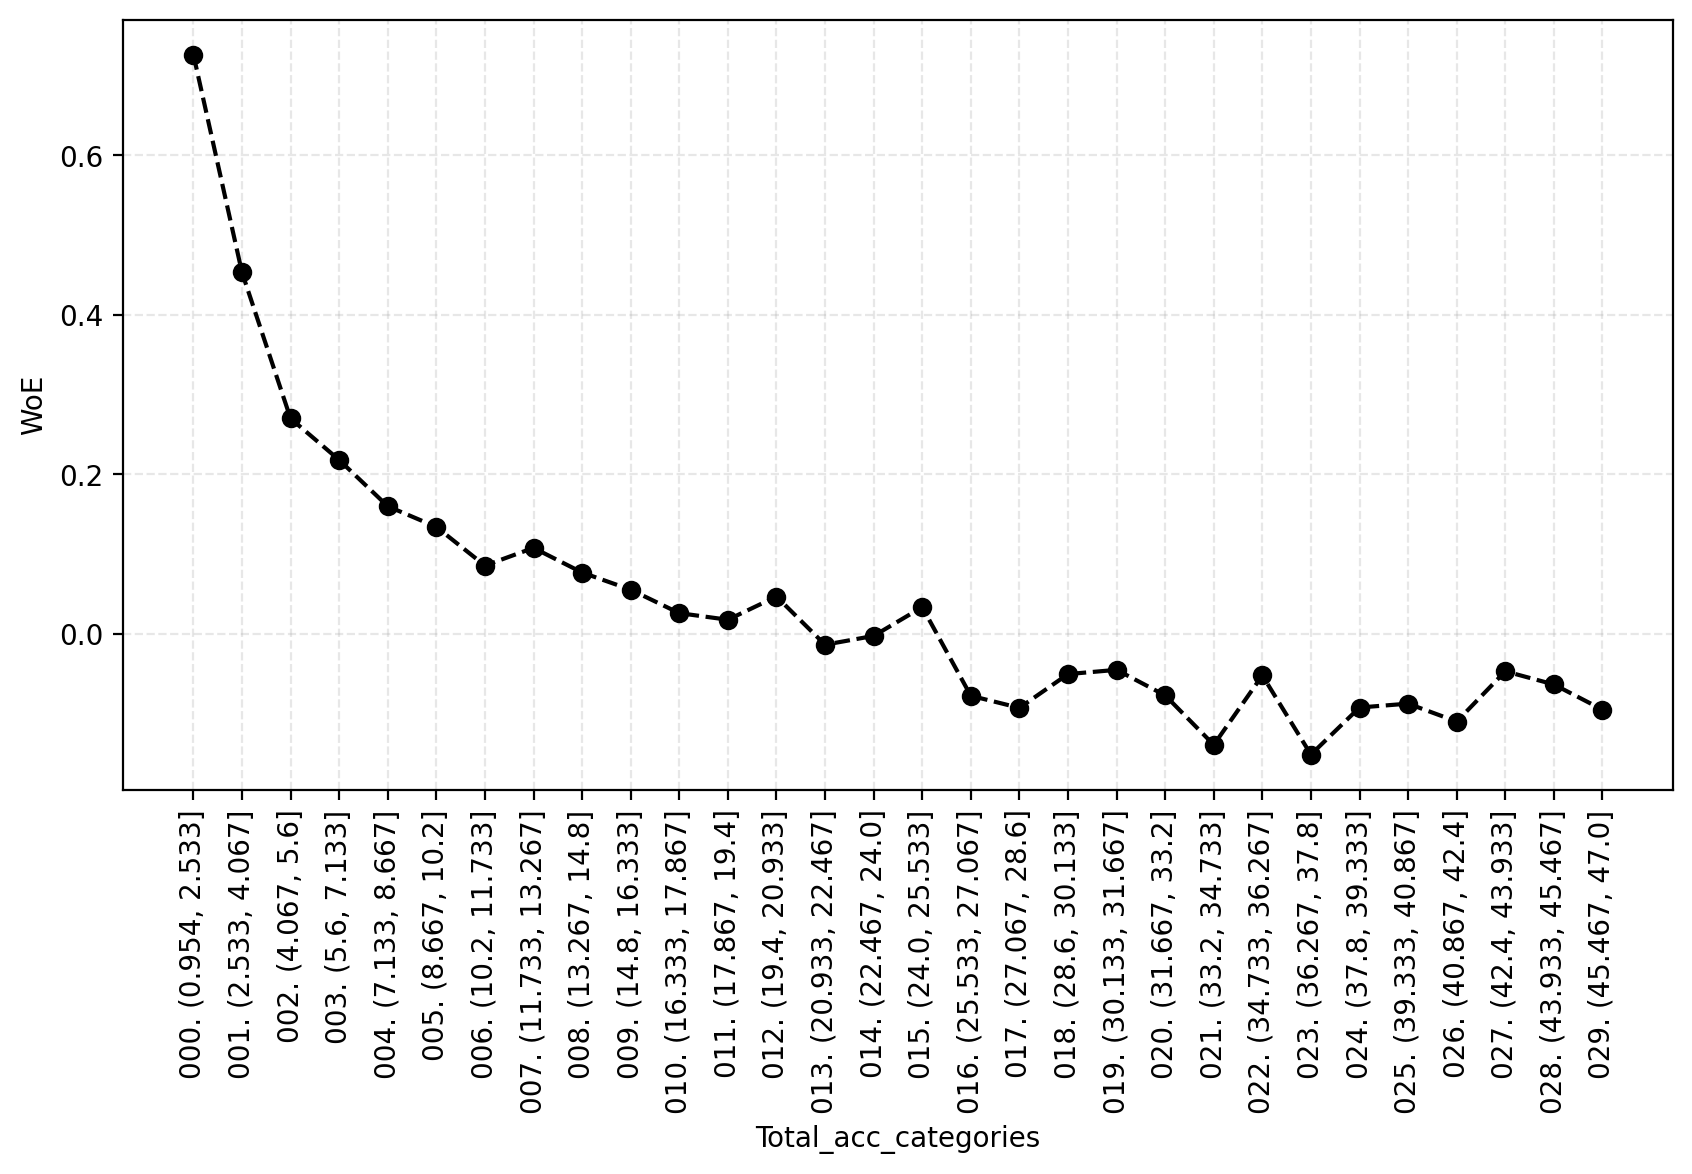

In [114]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [115]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    25,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [116]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "0-25")

13. `dti`

In [117]:
variable = "dti"
df_train[variable] = df_train[variable].fillna(df_train[variable].max())
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95, 0.999]))

0.00% missing!


count    373028.000000
mean         17.217185
std           7.851843
min           0.000000
25%          11.360000
50%          16.870000
75%          22.790000
90%          28.000000
95%          30.760000
99.9%        39.200000
max          39.990000
Name: dti, dtype: float64


In [118]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=20
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
dti_categories,,,,,,,
"000. (-0.04, 2.0]",4240,471,4711,0.012761,0.011551,-0.099605,0.026166
"001. (2.0, 3.999]",7961,771,8732,0.023961,0.018909,-0.236766,0.026166
"002. (3.999, 5.998]",13015,1245,14260,0.039172,0.030534,-0.249112,0.026166
"003. (5.998, 7.998]",18299,1741,20040,0.055075,0.042699,-0.254532,0.026166
"004. (7.998, 9.998]",22986,2307,25293,0.069182,0.056580,-0.201082,0.026166
"005. (9.998, 11.997]",27362,2844,30206,0.082353,0.069750,-0.166089,0.026166
"006. (11.997, 13.997]",30231,3297,33528,0.090988,0.080860,-0.118000,0.026166
"007. (13.997, 15.996]",31250,3480,34730,0.094055,0.085349,-0.097132,0.026166
"008. (15.996, 17.996]",30499,3728,34227,0.091794,0.091431,-0.003967,0.026166


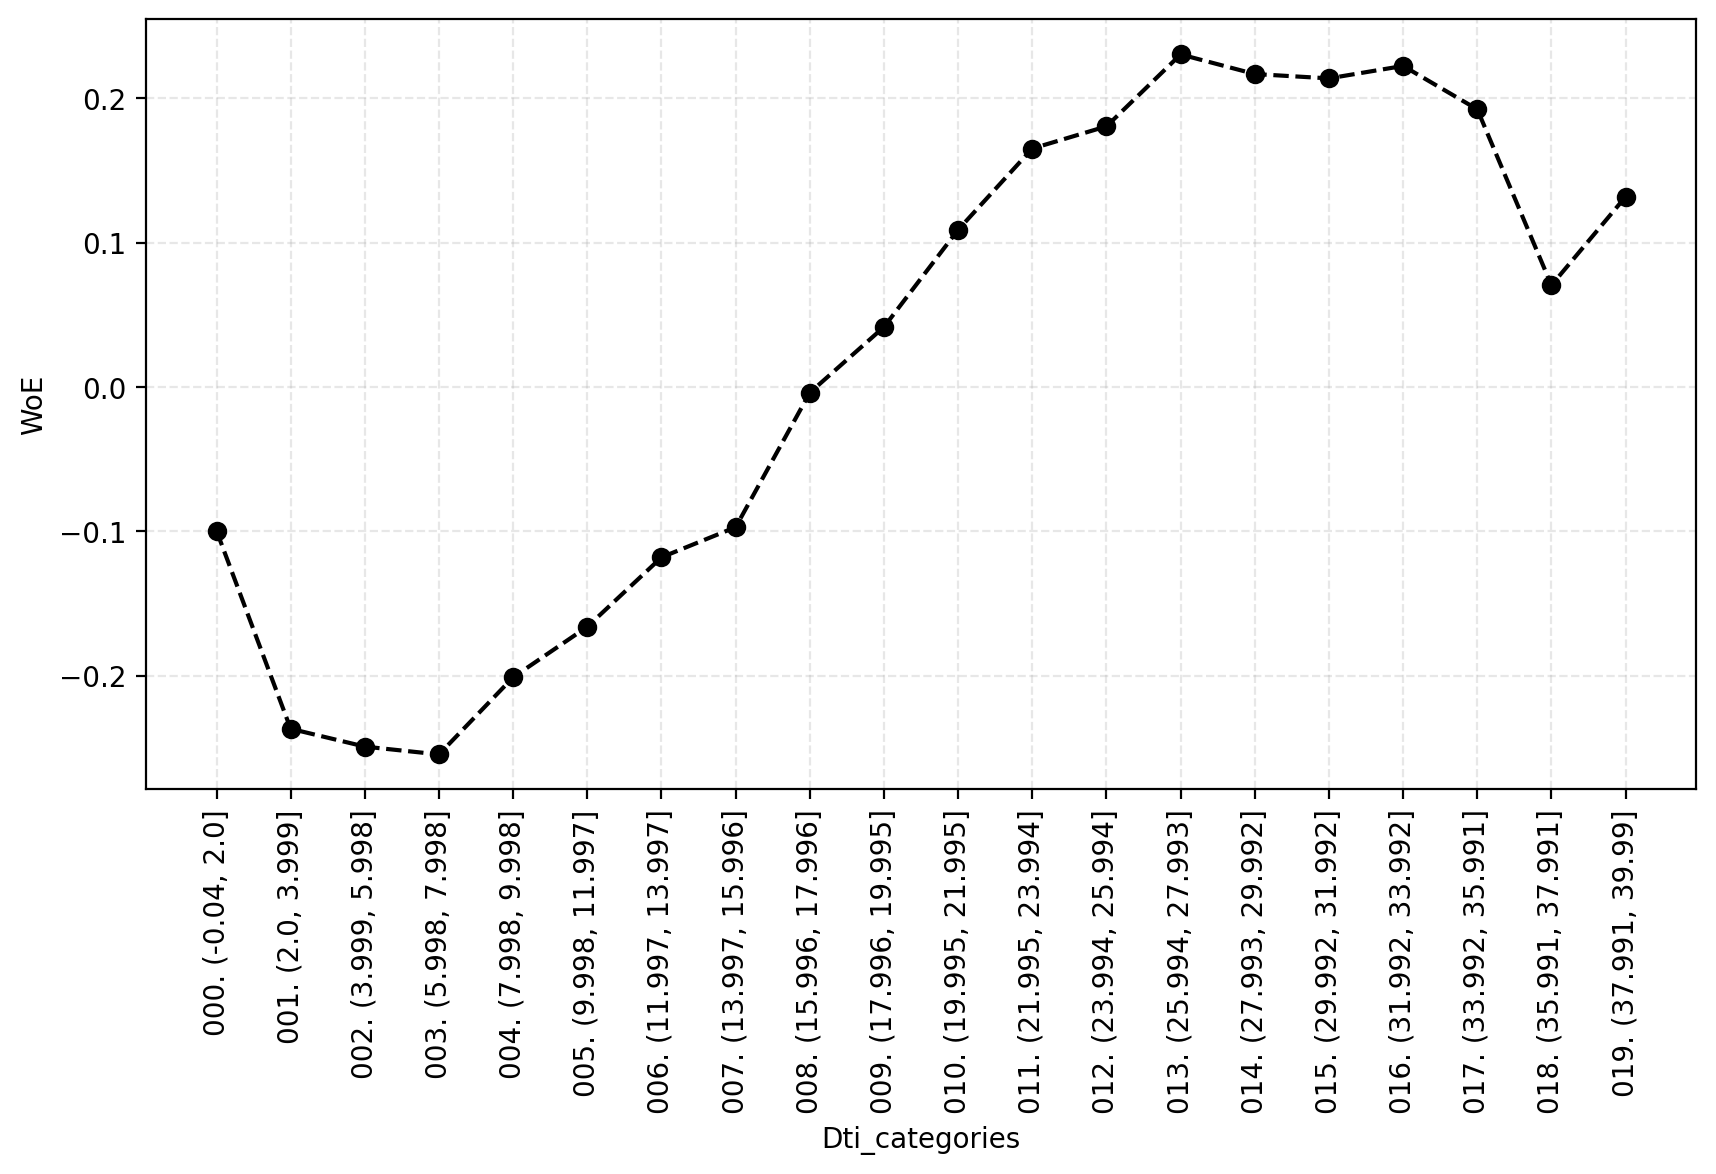

In [119]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [120]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    8,
    12,
    16,
    18,
    20,
    22,
    27,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [121]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "28-40")

14. `total_rev_hi_lim`

In [122]:
variable = "total_rev_hi_lim"
df_train[variable] = df_train[variable].fillna(df_train["funded_amnt"])
print(f"{100*df_train[variable].isnull().mean():.2f}% missing!\n\n")
print(df_train[variable].describe(percentiles=[0.25, 0.75, 0.90, 0.95, 0.999]))

0.00% missing!


count    3.730280e+05
mean     2.759895e+04
std      3.673022e+04
min      0.000000e+00
25%      1.160000e+04
50%      2.010000e+04
75%      3.460000e+04
90%      5.460000e+04
95%      7.230000e+04
99.9%    2.951260e+05
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64


We can see that this variable has a highly skewed distribution. Hence, let's winsorize values.

In [123]:
winsorizer = NumericWinsorizer(
    field_name=variable, upper=100_000
)
df_train = winsorizer.transform(df_train)
transformers.append(winsorizer)

In [124]:
ordered_buckets, (lower, upper) = get_fine_classes(
    df_train[variable], n_buckets=30
)
df_train[ordered_buckets.name] = ordered_buckets.values

,Non-Default,Default,Total Obs,% Non-Default,% Default,WoE,IV
total_rev_hi_lim_categories,,,,,,,
"000. (-100.0, 3333.333]",7817,1307,9124,0.023527,0.032055,0.309289,0.043118
"001. (3333.333, 6666.667]",24504,3595,28099,0.073751,0.088169,0.178563,0.043118
"002. (6666.667, 10000.0]",35133,4983,40116,0.105741,0.122210,0.144746,0.043118
"003. (10000.0, 13333.333]",32864,4452,37316,0.098912,0.109187,0.098831,0.043118
"004. (13333.333, 16666.667]",32785,4539,37324,0.098675,0.111321,0.120591,0.043118
"005. (16666.667, 20000.0]",30253,4116,34369,0.091054,0.100947,0.103142,0.043118
"006. (20000.0, 23333.333]",23605,2953,26558,0.071045,0.072424,0.019218,0.043118
"007. (23333.333, 26666.667]",21738,2774,24512,0.065426,0.068034,0.039084,0.043118
"008. (26666.667, 30000.0]",18403,2213,20616,0.055388,0.054275,-0.020310,0.043118


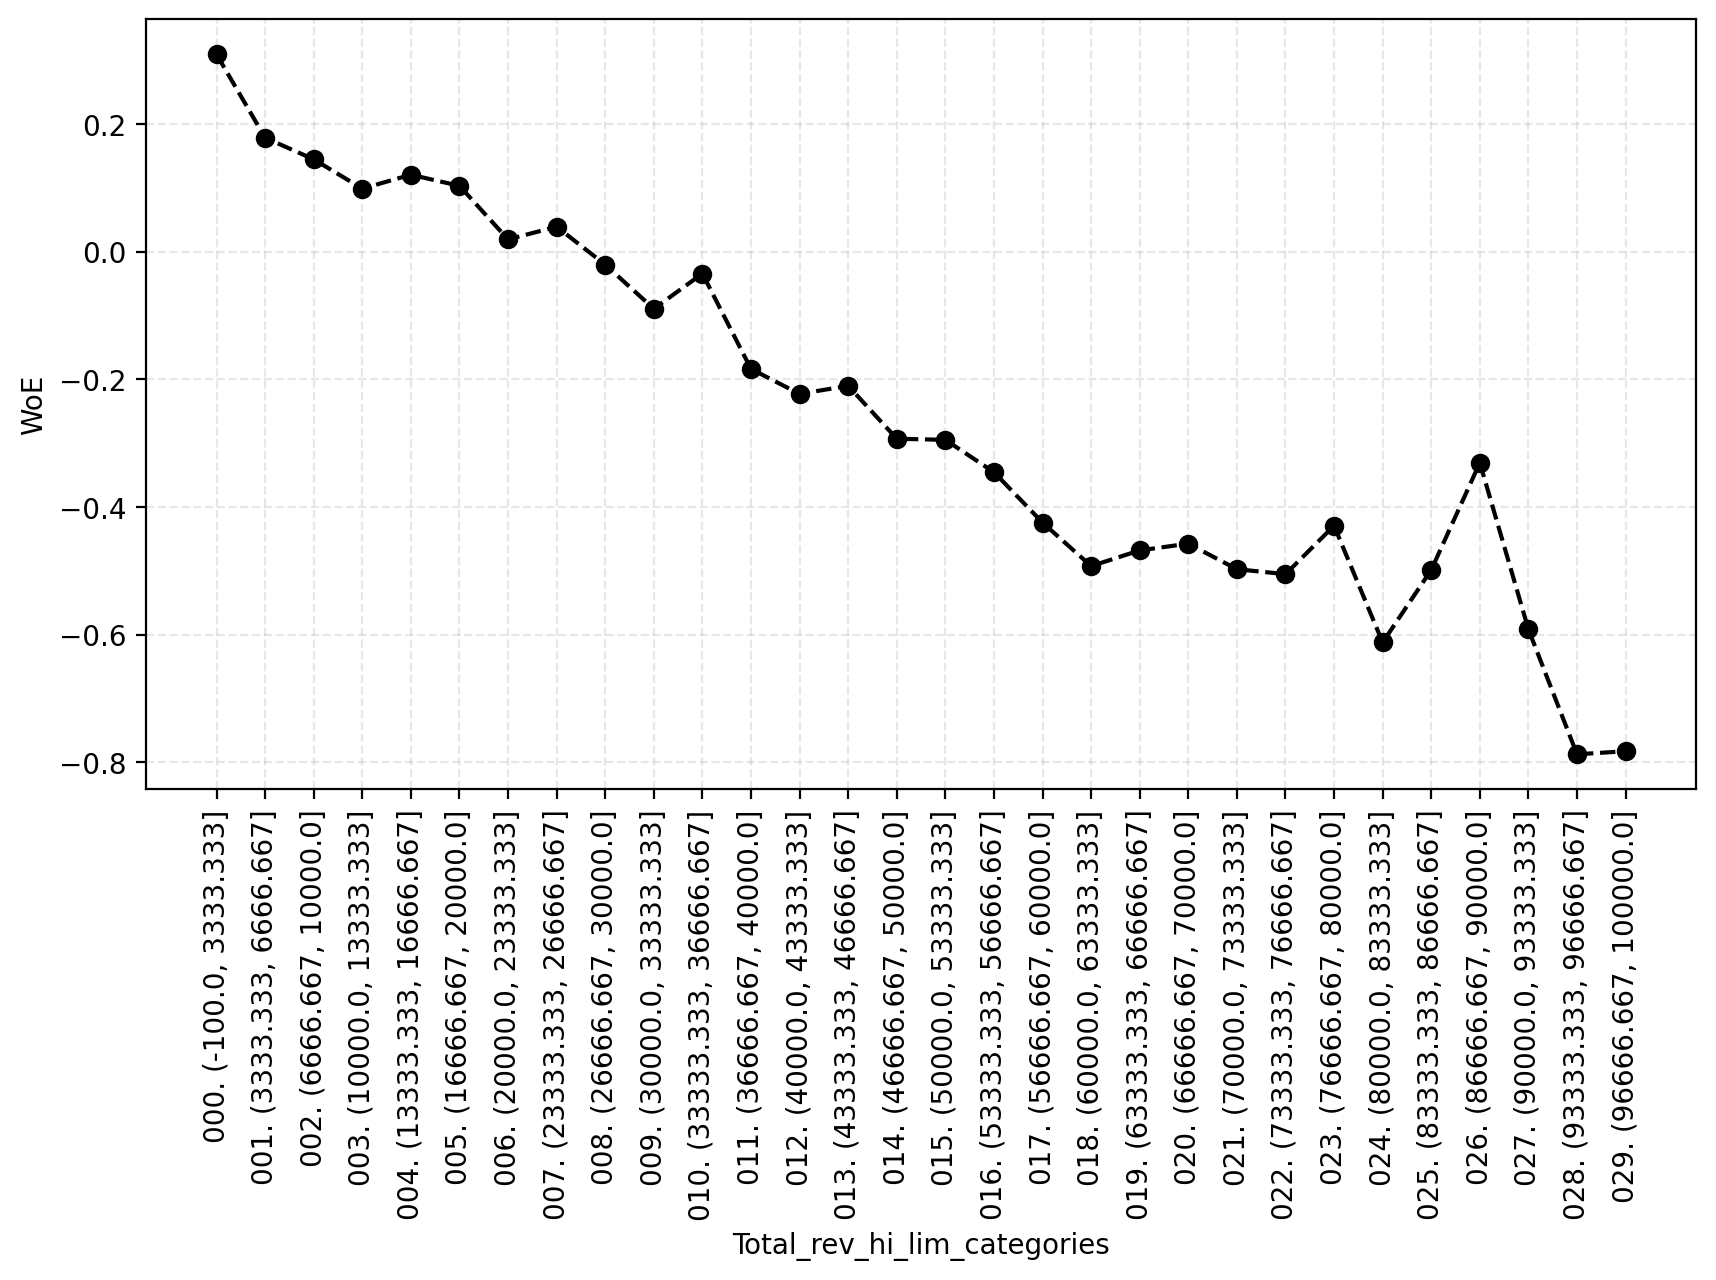

In [125]:
woe_df = compute_woe(
    df=df_train,
    id_column_name="id",
    feature_column_name=ordered_buckets.name,
    target_column_name=TARGET_VARIABLE,
    sort_by_woe=False
)
display(woe_df)
plot_woe_by_category(woe_df, rotate=True)

In [126]:
extractor = NumericCategoriesCreator(
    field_name=variable, boundaries = [
    lower,
    6_000,
    20_000,
    36_000,
    46_000,
    56_000,
    80_000,
    upper
])

df_train= extractor.transform(df_train)
transformers.append(extractor)

In [127]:
features += df_train.columns.tolist()[-len(extractor.boundaries)+1:]
reference_categories.append(f"{variable}_" + "-100-6000")

##### Applying same transformations to TEST DATASET

In [128]:
for transformer in transformers:
    df_test = transformer.transform(df_test)

#### Model development

Since we have dummy variables for K categories, and we cover all categories with K-1 dummy cariables, we'll need to remove one dummy variable from each variable group.

Logically, it makes sense for us to get rid of our **reference categories**, since they are the highest-risk category - hence for new borrowers and borrowers with missing information, we can simply leave all dummies with 0s.

In [129]:
final_features = list(
    filter(lambda x: x not in reference_categories, features)
)

The first step is to rely on Logistic Regression's model from `statsmodels` package, so that we can check p-values and choose features, according to their statistical significance.

In [158]:
exog = df_train[final_features]
exog = pd.concat([
    pd.DataFrame({"Intercept": np.ones(len(exog))}, index=exog.index),
    exog
], axis=1)
model = Logit(endog=df_train["default"], exog=exog)

In [159]:
model = model.fit()

Optimization terminated successfully.
         Current function value: 0.319904
         Iterations 8


In [160]:
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               373028
Model:                          Logit   Df Residuals:                   372926
Method:                           MLE   Df Model:                          101
Date:                Wed, 08 Feb 2023   Pseudo R-squ.:                 0.07290
Time:                        17:42:15   Log-Likelihood:            -1.1933e+05
converged:                       True   LL-Null:                   -1.2872e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.5508      0.142     10.951      0.000       1.273       1.828
grade_A                                    -

In [166]:
variable_group_not_significant = [
    "total_rev_hi_lim",
    "pub_rec",
    "total_acc",
    "delinq_2yrs",
    "open_acc",
]

final_features = list(
    filter(lambda x: "_".join(x.split("_")[:-1]) not in variable, final_features)
)
reference_categories = list(
    filter(lambda x: "_".join(x.split("_")[:-1]) not in variable, reference_categories)
)

Final model using `sklearn`

In [178]:
model = LogisticRegression(class_weight="balanced", random_state=99)
model.fit(df_train[final_features], df_train["default"])

/Users/gfluz94/.credit-risk/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=99)

In [181]:
pd.options.display.max_rows = 100
coefficients = pd.DataFrame({
    "Feature": ["Intercept"] + final_features,
    "Coefficient": [model.intercept_[0]] + model.coef_[0].tolist()
})
coefficients

,Feature,Coefficient
0,Intercept,3.628291
1,grade_A,-0.926712
2,grade_B,-0.911617
3,grade_C,-0.679548
4,grade_D,-0.544373
5,grade_E,-0.356466
6,grade_F,-0.175485
7,home_ownership_MORTGAGE,-0.116715
8,home_ownership_OWN,-0.092218
9,addr_state_HI,-0.131328
